
-----------------------------------------------------
### Notebook Documentation.
#### TFM
---------------------------------

- First 1 tried pickling the data => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/main/src/TFM-serializing_data.ipynb
- That consumed all RAM and wasn't great for batch processing with data augmentation (all pics were loaded in RAM at once). So I started using *image_dataset_from_directory* from *tensorflow* for batch processing, adding a layer for data augmentation => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/main/src/tfm_2021_01_03.ipynb
- This was not right, because while shuffling of pictures for *train_ds* and *val_ds* (this method can't split data into 3 sets) it lost the connection between labels and pics (they were shuffled), the nn weren't matching anything properly => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/main/src/tfm_debugging.ipynb
- So I created 3 folders for *train, test and val datasets*. Each of them had a representative sample and different volume => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/main/src/tfm_creating_2_folders_5_classes.ipynb
- Now it looks like everything is fine, but *train accuracy* is way worse than *val accuracy*. It can be caused because I have a dropout layer for training that maybe is cutting too much connections => https://github.com/albertovpd/viu_tfm-deep_vision_classification/blob/main/src/tfm_after_debugging_classification_report.ipynb

So, it's time to run all models and check what's going on.


PENDING:
- using gelu activation layers => https://keras.io/api/layers/activations/ and lrelu

In [ ]:
# Google Drive stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


- libraries

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Feb  6 18:08:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    45W / 350W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
# batch ingestion of pics without pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory

# nns
from tensorflow.keras.applications import VGG16, VGG19,Xception, InceptionResNetV2, DenseNet121, ResNet50 

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers # for data augmentation
#from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Flatten # Input, Conv2D, 
#from tensorflow.keras.layers import Layer

# optimization
from tensorflow.keras.optimizers import SGD # Adam, 
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_precision_recall_curve
from itertools import chain # to flatten the real labels array from validation set
import json # to save in a file metrics
#from datetime import datetime # to name results

# viz & arrays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# navigating through folder
import os

- paths

In [ ]:
# paths i'll use
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"

# the 5-folders dataset
#input = base_folder+"input/House_Room_Dataset-5_rooms" # for requesting directly pics

# folder 06 train set, 02 test set 01 val set
# folder06 = dataset_2_folders/"

# folder with 0.8 in split for training set, 0.15 for test and 0.05 for val
folder08 = "dataset_3folders_08trainset/"
input = base_folder+"input/"+folder08

src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

# insert the directory for using my functions in this notebook
import sys
sys.path.insert(0,"/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src/")

- functions

In [ ]:
def vgg19_vgg16(data_augmentation, base_model, dropout_layers: bool, dropout_position: str, dropout_percent: float, num_classes, acti_layer):
  '''
  both architectures has the same top model, so we'll built:
  - a model with/without a data augmentation layer
  - the functional nn with frozen layers, whithout top model
  - "empty" top model layers, ready for transfer-learning, with/without dropout in first/middle layer of top model
  - final layer with as much neurons as our classes to infer
  EX: vgg19(data_augmentation=None, base_model= base_model_vgg19, dropout_layers=False, dropout_position= None, dropout_percent=None, num_classes=5)
  '''
  pre_trained = Sequential()

  if data_augmentation:
    #data augmentation
    pre_trained.add(data_augmentation)
    pre_trained.add(layers.Rescaling(1./255))
       
                                                                 
  # vgg16 (Functional)          
  pre_trained.add(base_model)

  # Freeze the layers 
  for layer in pre_trained.layers:
      layer.trainable = False

  # ===> i had to insert this layer when using the data augmentation layer in order to avoid dimension errors with VGG16 and 19
  #pre_trained.add(layers.GlobalAveragePooling2D())

  # adding top model with/without dropout in first/middle position
  # top moddel for vgg19-16 are a flatten layer, 2 dense layers of 4096n and pred layer 
  pre_trained.add(layers.Flatten())
  if dropout_layers is True:
      if dropout_position=="first":
          pre_trained.add(layers.Dropout(dropout_percent)) 
          pre_trained.add(layers.Dense(4096,activation=(acti_layer)))

      elif dropout_position == "middle":                  
          pre_trained.add(layers.Dense(4096,activation=(acti_layer)))
          pre_trained.add(layers.Dropout(dropout_percent)) 
      
  else: 
    pre_trained.add(layers.Dense(4096,activation=(acti_layer)))
  
  pre_trained.add(layers.Dense(4096,activation=(acti_layer)))
  pre_trained.add(layers.Dense(num_classes,activation=('softmax')))

  return pre_trained

def generic_last_2layers(data_augmentation, nn,neurons_final_layer:int,  dropout_layers: bool, dropout_position: str =="first", dropout_percent: float):
  '''
  Xception, InceptionResNetV2, DenseNet121 have different architecture, but all of them have the same top model. So we add the data augmentation layer,
  load the functional model and add the top model with/without dropout in first/middle position
  works with pre-trained models (Xception, InceptionResNetV2, DenseNet121) for transfer-learning. 
  top layer consisting of 2 layers: globalaverage2d layer and predictions layer.
  - nn                  = pre-trained model without top model
  - neurons_final_layer = how many classes we want to work with
  - dropout_layers      = bool. dropout in the top model (True/False)
  - dropout_position    = dropout layer before top model or between dense layers (first/middle)
  - dropout_percent     = (0,1). float
  EX: generic_last_2layers(Xception(include_top=False, 
                                    weights='imagenet', 
                                    input_shape=(128, 128, 3), 
                                    classes = num_classes, 
                                    classifier_activation='softmax'
                                    ), 
                          5, True, "first", 0.2
                          )
  '''
  pre_trained = Sequential()

  if data_augmentation:
    #data augmentation
    pre_trained.add(data_augmentation)
    pre_trained.add(layers.Rescaling(1./255))

  pre_trained.add(nn)

  # Freeze the layers 
  for layer in pre_trained.layers:
      layer.trainable = False

  #adding top model with/without dropout
  if dropout_layers is True:
      if dropout_position=="first":
          pre_trained.add(layers.Dropout(dropout_percent)) 
          pre_trained.add(layers.GlobalAveragePooling2D()) # https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
          

      elif dropout_position == "middle":
          pre_trained.add(layers.GlobalAveragePooling2D()) 
          pre_trained.add(layers.Dropout(dropout_percent)) 
      
  else:
    pre_trained.add(layers.GlobalAveragePooling2D())
  
  # last layer
  pre_trained.add(layers.Dense(neurons_final_layer,activation=('softmax')))
  return pre_trained


def plotting_model(model, epochs, name, location):
  '''
  Plotting the training and validation loss and accuracy
  :model: nn
  :epochs
  :name: name to save the final image
  :location: path to save the image
  '''

  f,ax=plt.subplots(2, 1, figsize=(15,10))
  #Loss
  ax[0].plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
  ax[0].plot(np.arange(0, epochs), history.history["val_loss"], label="test_loss")
  ax[0].grid(visible=True, which="both", axis='both')
  ax[0].legend()

  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  #Accuracy
  ax[1].plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
  ax[1].plot(np.arange(0, epochs), history.history["val_accuracy"], label="test_acc")
  ax[1].grid(visible=True, which="both", axis='both')
  ax[1].legend()

  plt.xlabel("Run Epochs: "+str(epochs)+" ||    "+name)
  plt.ylabel("Loss/Accuracy")
  
  plt.savefig(location)
  plt.show()
  

def model_evaluation(evaluation, output_folder:str, name:str):
  '''
  evaluation the model with test_ds
  :evaluation: model.evaluate(val_dataset, batch_size, return_dict=True)
  :output_folder: path to save the json
  :name: name of the file
  '''
  models_metrics = {}  
  models_metrics[m] = evaluation
  # saving the metris in json file
  with open(output_folder+name+"-metrics.json", "w") as outfile:
    json.dump(models_metrics, outfile)
  return models_metrics

def classification_report_pic(y_pred, y_target, class_names, output_folder, name):
  '''
  prints inline the classification report and also saves a pic with results
  - y_pred = inferences: n.argmax( model.predict(test_ds), axis=1)
  - validation_ds = the test dataset (if you have 3 folders)
  - class_names
  - output_folder: the path to save the pic
  - name
  '''  
  print(classification_report(y_pred , y_target, target_names=class_names))

  
  clf_report = classification_report(y_pred , y_target, target_names=class_names, output_dict=True )
  # .iloc[:-1, :] to exclude support
  plt.figure(figsize = (10,8))
  plt.title("classification report: "+name)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
  plt.savefig(output_folder+name+"-classification_report.png")
  plt.show()

def confusion_matrix_report(y_pred, y_target,  class_names, output_folder, name):
  '''
  displays inline a pic and also saves it
  - y_pred: inferences
  - y_target: labels
  - class_names
  - output_folder: path to save pic
  - name
  '''
  
  cm = confusion_matrix(y_target, y_pred, normalize="true" ) #,  labels=[class_names])
  df_cm = pd.DataFrame(cm, index= [class_names], columns = [class_names])
  fig = plt.figure(figsize = (10,8))
  ax1 = fig.add_subplot(1,1,1)
  sns.set(font_scale=1.4) #for label size
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
  plt.title("confusion matrix: "+name)
  ax1.set_ylabel('True Values',fontsize=14)
  ax1.set_xlabel('Predicted Values',fontsize=14)
  plt.savefig(output_folder+name+"-confusion_matrix.png")
  plt.show()

# getting pics from folder instead of pickling them

In previous versions I used a pickled dataset to work with. That was quite a mess, because it loads the full dataset in memory, so sometimes the notebook crashed. Now I batch process the pictures with this keras method => https://keras.io/examples/vision/image_classification_from_scratch/
- *image_dataset_from_directory* has no train-test-val. it has just train-val.

In [ ]:
image_size = (128,128)
batch_size = 128 # 32

In [ ]:
# train set
# https://www.tensorflow.org/tutorials/images/classification
# i'll take the whole of the folder (already separated)
train_path = input+'train_ds/'
train_ds = image_dataset_from_directory(
    train_path,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    seed=None,
    validation_split=None, 
    subset=None,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb',
    shuffle=False 
)

Found 4208 files belonging to 5 classes.


In [ ]:
# i'll take the whole of the folder (already separated)
test_path = input+"test_ds"
test_ds = image_dataset_from_directory(
    test_path,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    seed=None,
    validation_split=None, 
    subset=None,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb',
    shuffle=False 
)

Found 787 files belonging to 5 classes.


In [ ]:
# i'll take the whole of the folder (already separated)
val_path = input+"val_ds"
val_ds = image_dataset_from_directory(
    val_path,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    seed=None,
    validation_split=None, 
    subset=None,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb',
    shuffle=False 
)

Found 265 files belonging to 5 classes.


In [ ]:
# checking numbers
paths = ['train_ds/', 'test_ds/','val_ds/']
for p in paths:
  for dir,subdir,files in os.walk(input + p):
    print(dir,' => ', p, str(len(files)))

/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/train_ds/  =>  train_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/train_ds/Kitchen  =>  train_ds/ 772
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/train_ds/Livingroom  =>  train_ds/ 1028
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/train_ds/Dinning  =>  train_ds/ 926
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/train_ds/Bathroom  =>  train_ds/ 484
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/train_ds/Bedroom  =>  train_ds/ 998
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input/dataset_3folders_08trainset/test_ds/  =>  test_ds/ 0
/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/input

In [ ]:
class_names = train_ds.class_names
class_names

['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']

# data augmentation

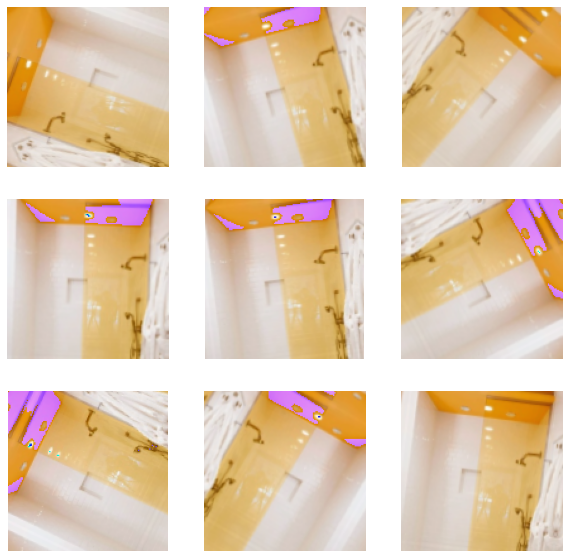

In [ ]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x
def random_invert(factor=0.3):
  return layers.Lambda(lambda x: random_invert_img(x, factor))


# to check => https://stepup.ai/custom_data_augmentation_keras/
# https://github.com/dufourpascal/stepupai/tree/master/tutorials/data_augmentation

# https://www.tensorflow.org/guide/keras/preprocessing_layers
data_augmentation = Sequential(  
  [  
  #random_invert(), # making the model to malfunction, errors in the for loop below
  layers.RandomFlip("horizontal",input_shape=(image_size[0],image_size[1],3)),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.01),    
  layers.RandomWidth(0.01),
  layers.RandomHeight(0.01),
  #layers.RandomTranslation((-0.1,0.1),(-0.1,0.1), fill_mode='constant',interpolation='bilinear', seed=None, fill_value=0.0)
  layers.RandomContrast(0.1)    
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# vgg19 with/without data augmentation

In [ ]:
# VGG16
base_model_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5, classifier_activation='softmax')
base_model_vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5, classifier_activation='softmax')
base_model_xception    =  Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5, classifier_activation='softmax')
base_model_inception   = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5, classifier_activation='softmax')
base_model_densenet121 = DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5) # has no classifier activation args
base_model_resnet50    = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5) # has no classifier activation args

models_dict = {
    # vgg16
    #"vgg16_NOdataAug_NOdropout"      : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "relu"),
    # #"vgg16_NOdataAug_NOdropout_gelu" : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "gelu"),

    # "vgg16_dataAug_dropoutFirst02"   : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg16_dataAug_dropoutFirst02_gelu": vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "gelu"),

    # "vgg16_NOdataAug_dropoutFirst02" : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg16_NOdataAug_dropoutFirst02_gelu" : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "gelu"),

    # "vgg16_dataAug_dropoutMiddle02"  : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg16_dataAug_dropoutMiddle02_gelu"  : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "gelu"),

    # "vgg16_NOdataAug_dropoutMiddle02": vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg16_NOdataAug_dropoutMiddle02_gelu": vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg16, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "gelu"),

    # "vgg16_dataAug_NOdropout"        : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "relu"),
    # "vgg16_dataAug_NOdropout_gelu"        : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg16, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "gelu"),   

    # # vgg19
    # "vgg19_NOdataAug_NOdropout"      : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "relu"),
    # "vgg19_NOdataAug_NOdropout_gelu"      : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "gelu"),

    # "vgg19_dataAug_dropoutFirst02"   : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg19_dataAug_dropoutFirst02_gelu"   : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "gelu"),
    
    # "vgg19_NOdataAug_dropoutFirst02" : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg19_NOdataAug_dropoutFirst02_gelu" : vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "first",  dropout_percent=0.2,  num_classes=5, "gelu"),

    # "vgg19_dataAug_dropoutMiddle02"  : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg19_dataAug_dropoutMiddle02_gelu"  : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "gelu"),
    
    # "vgg19_NOdataAug_dropoutMiddle02": vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "relu"),
    # "vgg19_NOdataAug_dropoutMiddle02_gelu": vgg19_vgg16(data_augmentation=None,               base_model= base_model_vgg19, dropout_layers=True,  dropout_position= "middle", dropout_percent=0.2,  num_classes=5, "gelu"),
    
    # "vgg19_dataAug_NOdropout"        : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "relu"),
    # "vgg19_dataAug_NOdropout_gelu"        : vgg19_vgg16(data_augmentation=data_augmentation,  base_model= base_model_vgg19, dropout_layers=False, dropout_position= None,     dropout_percent=None, num_classes=5, "gelu"),
    
    # xception
    #"xception_NOdataAug_NOdropout"     : generic_last_2layers(data_augmentation=None,  nn=base_model_xception, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    # "xception_dataAug_NOdropout"       : generic_last_2layers(data_augmentation,       nn=base_model_xception, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    # "xception_dataAug_dropoutFirst02"  : generic_last_2layers(data_augmentation,       nn=base_model_xception, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    # "xception_NOdataAug_dropoutFirst02": generic_last_2layers(data_augmentation= None, nn=base_model_xception, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    # "xception_dataAug_dropoutMid02"    : generic_last_2layers(data_augmentation,       nn=base_model_xception, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    # "xception_NOdataAug_dropoutMid02"  : generic_last_2layers(data_augmentation= None, nn=base_model_xception, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    
    # # inception resnet v2
    # "InceptionResNetV2_Aug_NOdropout"     : generic_last_2layers(data_augmentation=None,  nn=base_model_inception, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    # "InceptionResNetV2_dataAug_NOdropout"       : generic_last_2layers(data_augmentation,       nn=base_model_inception, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    # "InceptionResNetV2_dataAug_dropoutFirst02"  : generic_last_2layers(data_augmentation,       nn=base_model_inception, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    # "InceptionResNetV2_NOdataAug_dropoutFirst02": generic_last_2layers(data_augmentation= None, nn=base_model_inception, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    # "InceptionResNetV2_dataAug_dropoutMid02"    : generic_last_2layers(data_augmentation,       nn=base_model_inception, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    # "InceptionResNetV2_NOdataAug_dropoutMid02"  : generic_last_2layers(data_augmentation= None, nn=base_model_inception, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),

    # # densenet121
    # "densenet121_NOdataAug_NOdropout"     : generic_last_2layers(data_augmentation=None,  nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    # --"densenet121_dataAug_NOdropout"       : generic_last_2layers(data_augmentation,       nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    # "densenet121_dataAug_dropoutFirst02"  : generic_last_2layers(data_augmentation,       nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    # "densenet121_NOdataAug_dropoutFirst02": generic_last_2layers(data_augmentation= None, nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    # "densenet121_dataAug_dropoutMid02"    : generic_last_2layers(data_augmentation,       nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    # "densenet121_NOdataAug_dropoutMid02"  : generic_last_2layers(data_augmentation= None, nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),

    # # resnet50
    # "resnet50_dataAug_NOdropout"       : generic_last_2layers(data_augmentation,       nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),
    # -- "resnet50_dataAug_dropoutFirst02"  : generic_last_2layers(data_augmentation,       nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    "resnet50_NOdataAug_dropoutFirst02": generic_last_2layers(data_augmentation= None, nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.2),
    "resnet50_NOdataAug_dropoutFirst007": generic_last_2layers(data_augmentation= None, nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="first",  dropout_percent = 0.07),
    "resnet50_NOdataAug_NOdropout"     : generic_last_2layers(data_augmentation=None,  nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=False, dropout_position=None,     dropout_percent = None),

    # -- "resnet50_dataAug_dropoutMid02"    : generic_last_2layers(data_augmentation,       nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
    # "resnet50_NOdataAug_dropoutMid02"  : generic_last_2layers(data_augmentation= None, nn=base_model_resnet50, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2),
}

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
opt = SGD(momentum=0.9) # lr=0.01, 

callbacks = [
    EarlyStopping(
        # Stop training when the metric is no longer improving
        monitor='val_loss', mode="min", #"val_accuracy", mode="max", #  "val_loss",
        # "no longer improving" being defined as "no better than 1e-4 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=15,
        verbose=1
    )
]


 xception_dataAug_NOdropout
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20,871,725
Trainable params: 10,245
Non-trainable params: 20,861,480
________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 124s 4s/step - loss: 9.1315 - accuracy: 0.3562 - val_loss: 27.0475 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 101ms/step - loss: 36.0233 - accuracy: 0.0299 - val_loss: 19.3586 - val_accuracy: 0.2008
Epoch 3/100
33/33 [==============================] - 3s 94ms/step - loss: 24.3910 - accuracy: 0.0915 - val_loss: 9.1739 - val_accuracy: 0.3380
Epoch 4/100
33/33 [==============================] - 3s 103ms/step - loss: 26.6418 - accuracy: 0.1150 - val_loss: 9.1661 - val_accuracy: 0.3812
Epoch 5/100
33/33 [==============================] - 3s 92ms/step - loss: 26.0655 - accuracy: 0.1017 - val_loss: 10.6912 - val_accuracy: 0.3278
Epoch 6/100
33/33 [==============================] - 3s 94ms/step - loss: 25.3513 - accuracy: 0.0863 - val_loss: 12.0220 - val_accuracy: 0.3202
Epoch 7/100
33/33 [==============================] - 3s 95ms/step - loss: 25.3153 - accuracy: 0.0806 - val_loss: 9.7883 - val_accuracy: 0.3685
Epoch 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


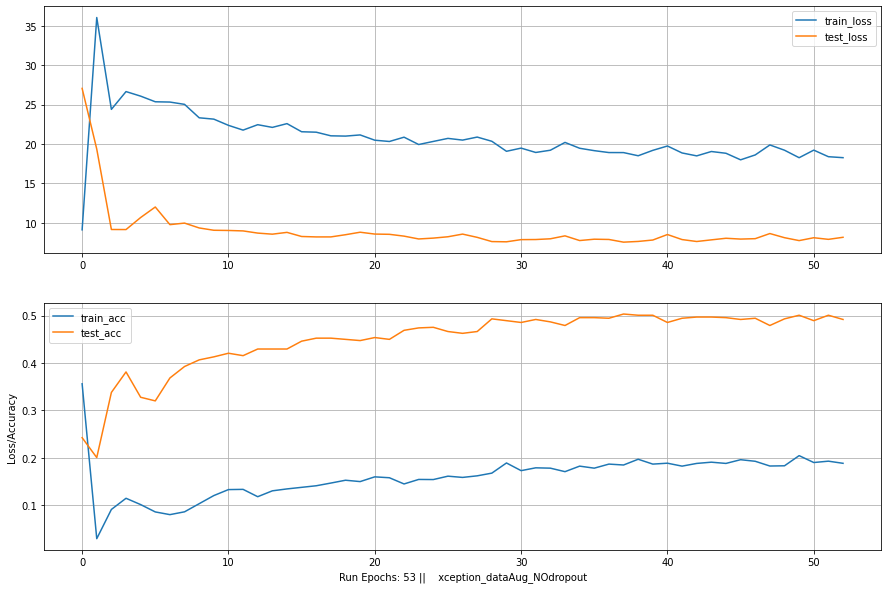

7/7 [==============================] - 1s 84ms/step - loss: 8.1861 - accuracy: 0.4917
              precision    recall  f1-score   support

     Bedroom       0.44      0.69      0.54       121
    Bathroom       0.22      0.74      0.34        27
     Dinning       0.45      0.76      0.56       103
  Livingroom       0.38      0.53      0.44       135
     Kitchen       0.93      0.33      0.49       401

    accuracy                           0.49       787
   macro avg       0.48      0.61      0.47       787
weighted avg       0.67      0.49      0.49       787



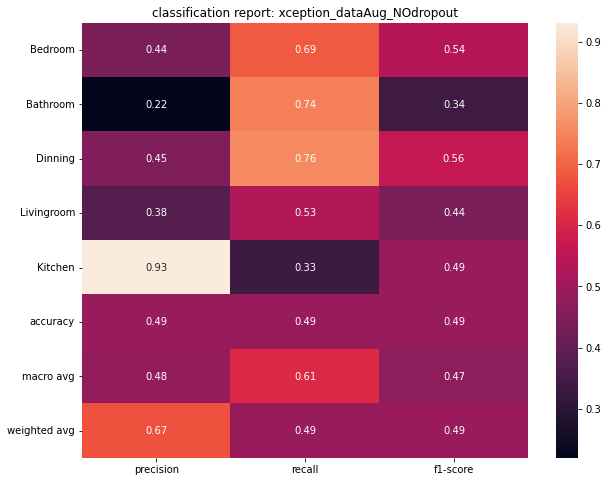

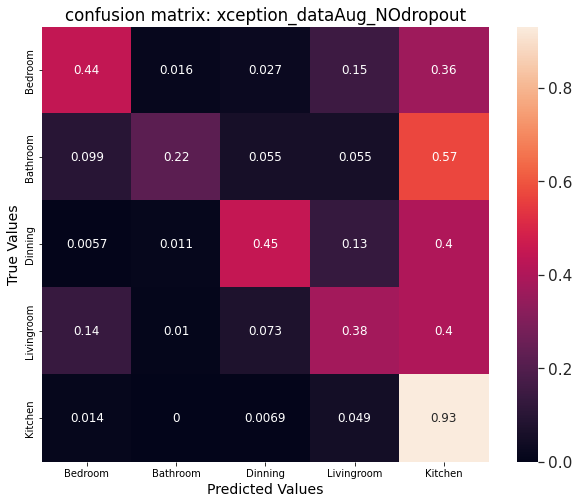


 xception_dataAug_dropoutFirst02
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_1 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 7s 116ms/step - loss: 9.7970 - accuracy: 0.3308 - val_loss: 25.5678 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 96ms/step - loss: 36.0178 - accuracy: 0.0192 - val_loss: 17.9855 - val_accuracy: 0.2122
Epoch 3/100
33/33 [==============================] - 3s 94ms/step - loss: 26.6201 - accuracy: 0.0775 - val_loss: 7.6513 - val_accuracy: 0.3456
Epoch 4/100
33/33 [==============================] - 3s 95ms/step - loss: 26.2849 - accuracy: 0.0848 - val_loss: 8.9203 - val_accuracy: 0.3672
Epoch 5/100
33/33 [==============================] - 3s 94ms/step - loss: 27.4252 - accuracy: 0.0965 - val_loss: 11.5590 - val_accuracy: 0.3329
Epoch 6/100
33/33 [==============================] - 3s 94ms/step - loss: 25.9672 - accuracy: 0.0687 - val_loss: 10.1313 - val_accuracy: 0.3571
Epoch 7/100
33/33 [==============================] - 3s 91ms/step - loss: 23.6403 - accuracy: 0.0939 - val_loss: 9.6355 - val_accuracy: 0.3710
Epoch 8

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


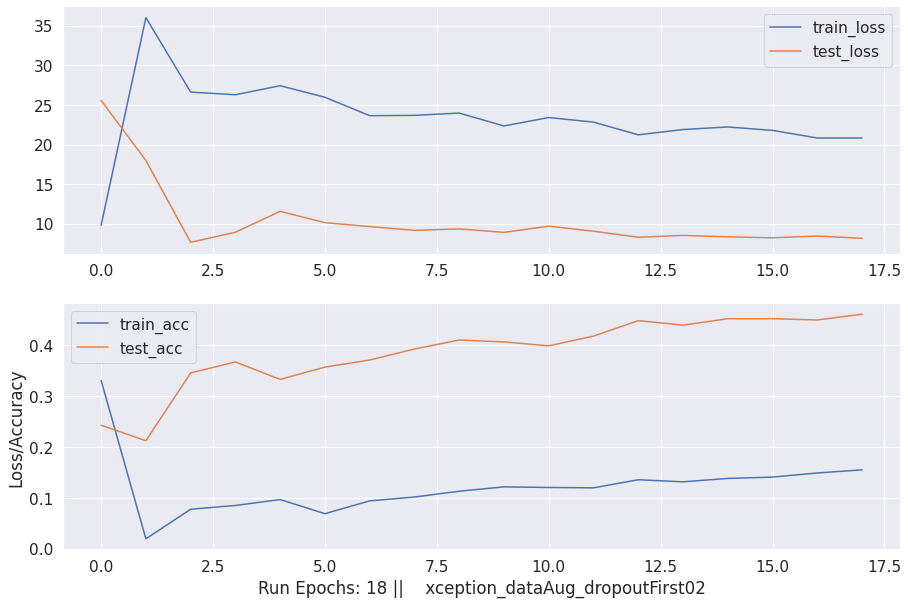

7/7 [==============================] - 1s 96ms/step - loss: 8.1553 - accuracy: 0.4612
              precision    recall  f1-score   support

     Bedroom       0.42      0.62      0.50       128
    Bathroom       0.31      0.76      0.44        37
     Dinning       0.42      0.70      0.53       104
  Livingroom       0.27      0.53      0.35        97
     Kitchen       0.92      0.31      0.47       421

    accuracy                           0.46       787
   macro avg       0.47      0.58      0.46       787
weighted avg       0.66      0.46      0.47       787



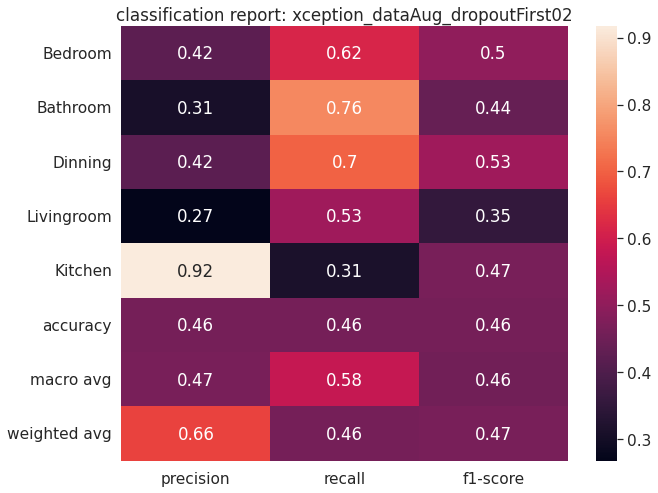

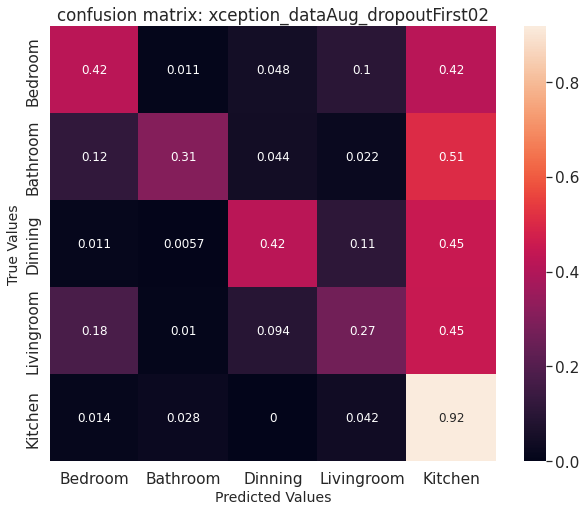


 xception_NOdataAug_dropoutFirst02
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 20,871,725
Trainable params: 10,245
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 6s 126ms/step - loss: 10449.6504 - accuracy: 0.3729 - val_loss: 39873.3086 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 93ms/step - loss: 50399.7812 - accuracy: 0.0539 - val_loss: 26189.2559 - val_accuracy: 0.1830
Epoch 3/100
33/33 [==============================] - 3s 91ms/step - loss: 27660.1699 - accuracy: 0.2205 - val_loss: 30580.4922 - val_accuracy: 0.2427
Epoch 4/100
33/33 [==============================] - 3s 92ms/step - loss: 38148.0234 - accuracy: 0.0273 - val_loss: 19824.5176 - val_accuracy: 0.2630
Epoch 5/100
33/33 [==============================] - 3s 94ms/step - loss: 40175.5117 - accuracy: 0.1136 - val_loss: 19169.1738 - val_accuracy: 0.1842
Epoch 6/100
33/33 [==============================] - 3s 92ms/step - loss: 32168.2129 - accuracy: 0.0967 - val_loss: 22458.8379 - val_accuracy: 0.2592
Epoch 7/100
33/33 [==============================] - 3s 91ms/step - loss: 32364.1172 - accuracy: 0.0784 - val_l

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


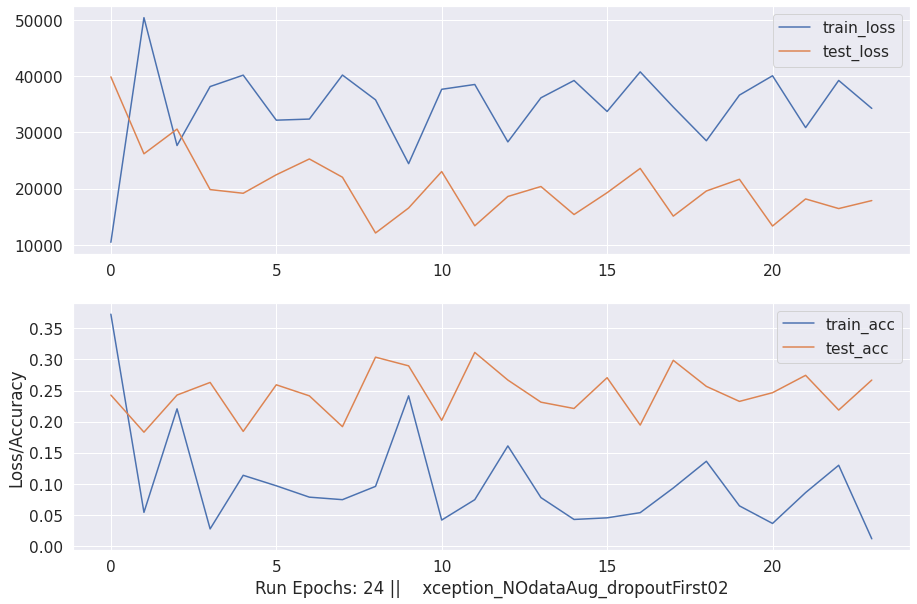

7/7 [==============================] - 1s 88ms/step - loss: 17868.1055 - accuracy: 0.2668


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

              precision    recall  f1-score   support

     Bedroom       0.00      0.00      0.00         0
    Bathroom       0.11      0.53      0.18        19
     Dinning       0.00      0.00      0.00         1
  Livingroom       0.53      0.32      0.40       315
     Kitchen       0.69      0.22      0.33       452

    accuracy                           0.27       787
   macro avg       0.27      0.21      0.18       787
weighted avg       0.61      0.27      0.35       787



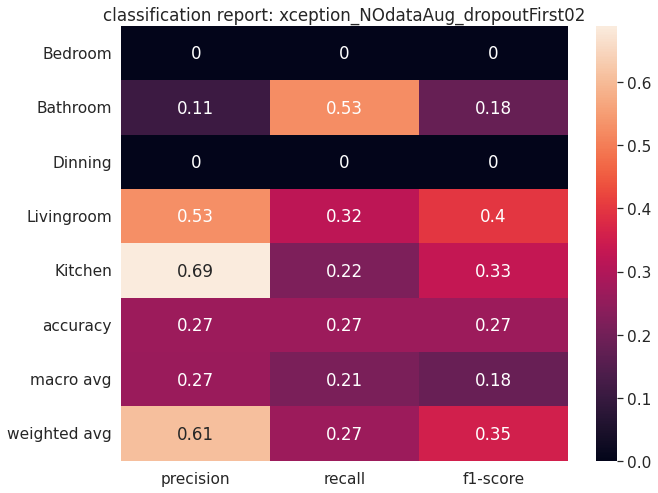

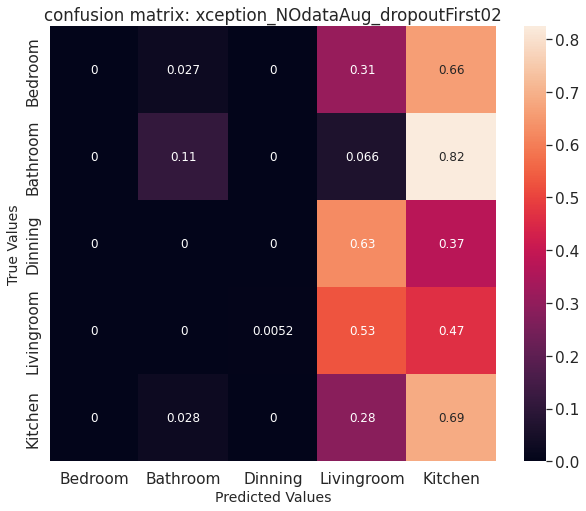


 xception_dataAug_dropoutMid02
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_2 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 10245     
                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 7s 116ms/step - loss: 9.3890 - accuracy: 0.3676 - val_loss: 27.3734 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 97ms/step - loss: 36.4418 - accuracy: 0.0152 - val_loss: 17.2940 - val_accuracy: 0.2046
Epoch 3/100
33/33 [==============================] - 3s 94ms/step - loss: 25.2193 - accuracy: 0.0979 - val_loss: 8.4293 - val_accuracy: 0.3507
Epoch 4/100
33/33 [==============================] - 3s 100ms/step - loss: 25.3306 - accuracy: 0.1224 - val_loss: 7.4019 - val_accuracy: 0.3672
Epoch 5/100
33/33 [==============================] - 3s 95ms/step - loss: 27.4735 - accuracy: 0.0986 - val_loss: 11.3825 - val_accuracy: 0.3037
Epoch 6/100
33/33 [==============================] - 3s 94ms/step - loss: 25.4076 - accuracy: 0.0770 - val_loss: 10.2465 - val_accuracy: 0.3393
Epoch 7/100
33/33 [==============================] - 3s 93ms/step - loss: 23.8994 - accuracy: 0.0903 - val_loss: 9.3382 - val_accuracy: 0.3672
Epoch 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


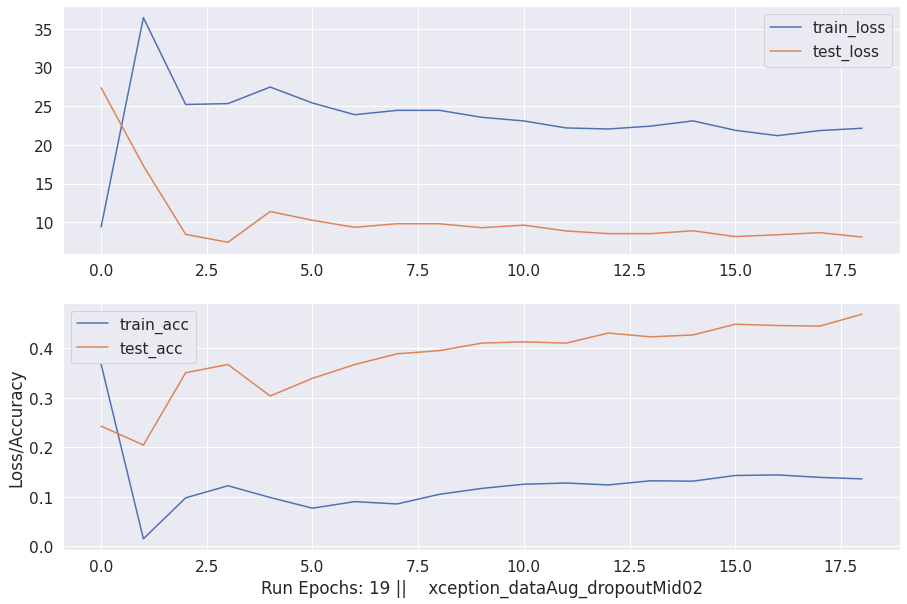

7/7 [==============================] - 1s 83ms/step - loss: 8.0814 - accuracy: 0.4689
              precision    recall  f1-score   support

     Bedroom       0.42      0.62      0.50       125
    Bathroom       0.30      0.77      0.43        35
     Dinning       0.47      0.70      0.56       117
  Livingroom       0.26      0.53      0.35        93
     Kitchen       0.92      0.32      0.47       417

    accuracy                           0.47       787
   macro avg       0.47      0.59      0.46       787
weighted avg       0.67      0.47      0.47       787



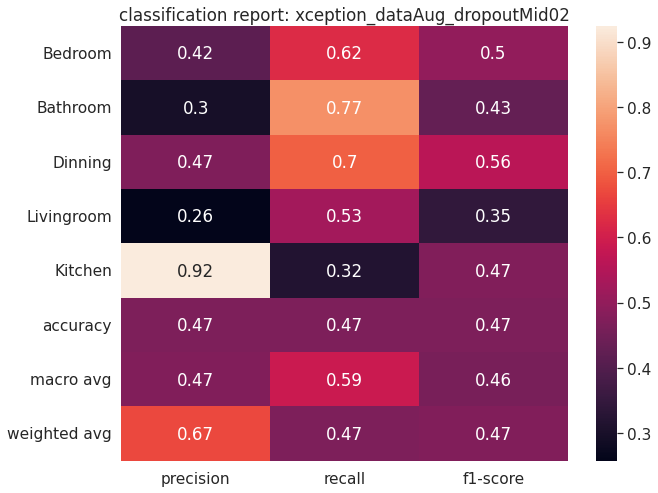

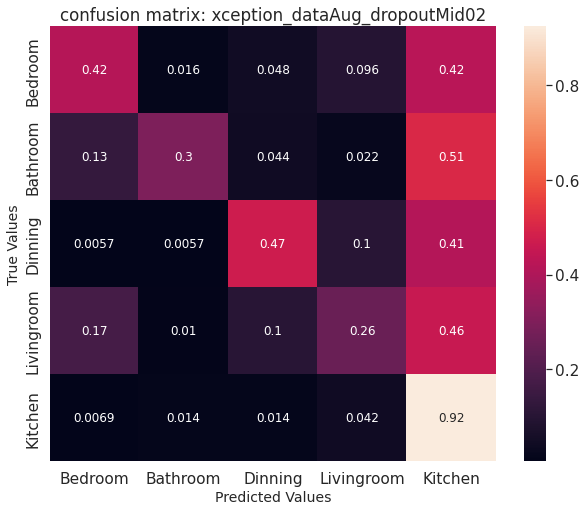


 xception_NOdataAug_dropoutMid02
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 20,871,725
Trainable params: 10,245
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 6s 120ms/step - loss: 6773.4932 - accuracy: 0.5135 - val_loss: 38958.8086 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 93ms/step - loss: 45859.8633 - accuracy: 0.0000e+00 - val_loss: 26315.3770 - val_accuracy: 0.1893
Epoch 3/100
33/33 [==============================] - 3s 95ms/step - loss: 41771.1055 - accuracy: 0.0383 - val_loss: 12741.6660 - val_accuracy: 0.3024
Epoch 4/100
33/33 [==============================] - 3s 94ms/step - loss: 31265.4727 - accuracy: 0.1369 - val_loss: 18100.8086 - val_accuracy: 0.2605
Epoch 5/100
33/33 [==============================] - 3s 93ms/step - loss: 38419.1133 - accuracy: 0.0278 - val_loss: 19933.8809 - val_accuracy: 0.1855
Epoch 6/100
33/33 [==============================] - 3s 96ms/step - loss: 37404.5117 - accuracy: 0.0138 - val_loss: 17043.0254 - val_accuracy: 0.2592
Epoch 7/100
33/33 [==============================] - 3s 94ms/step - loss: 37916.1641 - accuracy: 0.0150 - va

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


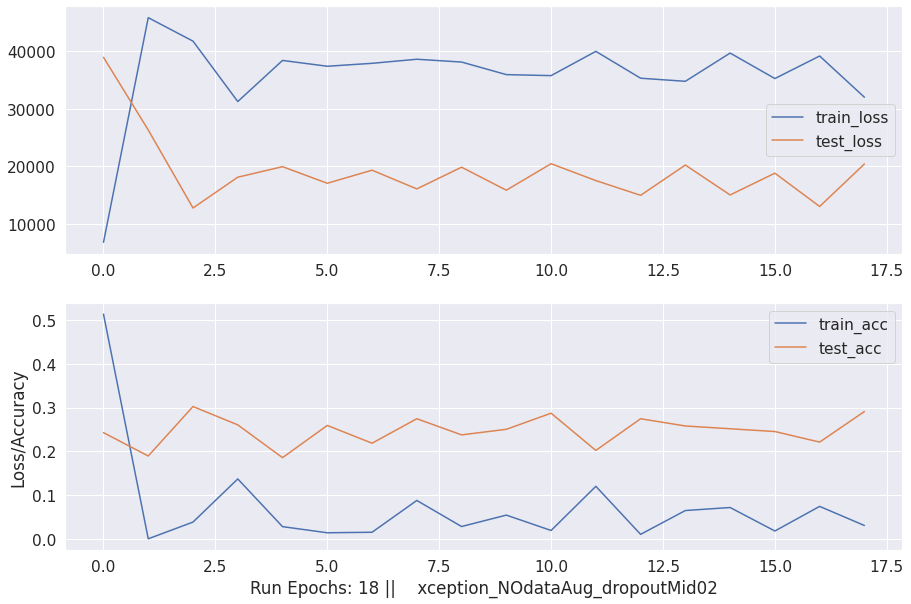

7/7 [==============================] - 1s 80ms/step - loss: 20401.4629 - accuracy: 0.2910


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

              precision    recall  f1-score   support

     Bedroom       0.00      0.00      0.00         0
    Bathroom       0.00      0.00      0.00         0
     Dinning       0.07      0.30      0.12        43
  Livingroom       0.81      0.31      0.44       503
     Kitchen       0.43      0.26      0.32       241

    accuracy                           0.29       787
   macro avg       0.26      0.17      0.18       787
weighted avg       0.65      0.29      0.39       787



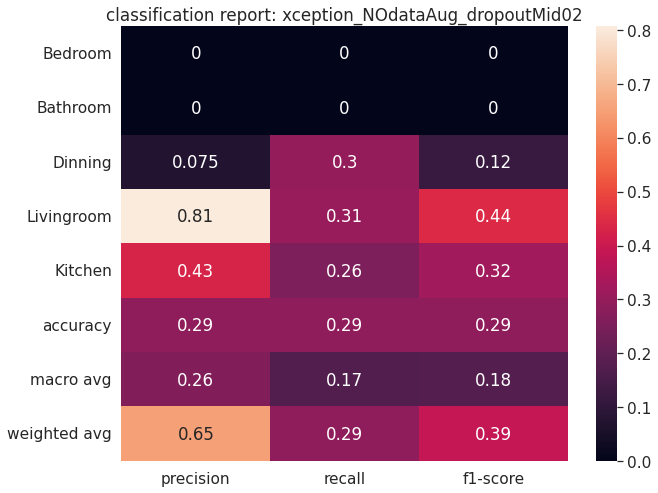

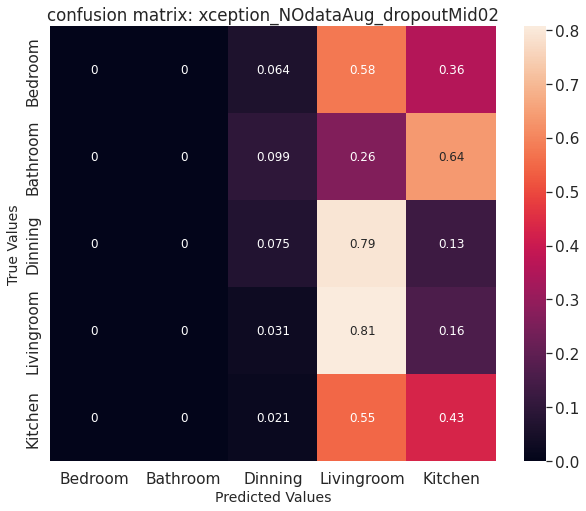


 InceptionResNetV2_Aug_NOdropout
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_5   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 5)                 7685      
                                                                 
Total params: 54,344,421
Trainable params: 7,685
Non-trainable params: 54,336,736
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 18s 256ms/step - loss: 1278073.1250 - accuracy: 0.4225 - val_loss: 5710513.5000 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 4s 127ms/step - loss: 7262826.0000 - accuracy: 0.0176 - val_loss: 3307268.0000 - val_accuracy: 0.1156
Epoch 3/100
33/33 [==============================] - 4s 127ms/step - loss: 4532860.5000 - accuracy: 0.1150 - val_loss: 2698789.5000 - val_accuracy: 0.2427
Epoch 4/100
33/33 [==============================] - 4s 128ms/step - loss: 5713393.0000 - accuracy: 0.0000e+00 - val_loss: 1922479.6250 - val_accuracy: 0.1830
Epoch 5/100
33/33 [==============================] - 4s 125ms/step - loss: 5117890.5000 - accuracy: 0.1122 - val_loss: 3666824.2500 - val_accuracy: 0.2427
Epoch 6/100
33/33 [==============================] - 4s 125ms/step - loss: 5294078.5000 - accuracy: 0.0266 - val_loss: 3938711.2500 - val_accuracy: 0.2427
Epoch 7/100
33/33 [==============================] - 4s 127ms/step - loss: 48

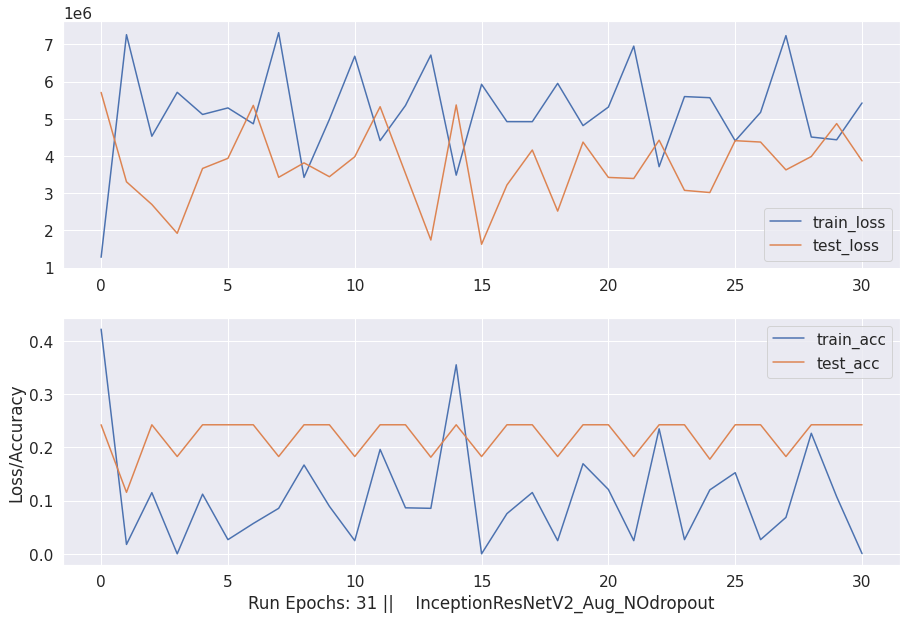

7/7 [==============================] - 1s 116ms/step - loss: 3870737.5000 - accuracy: 0.2427


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

              precision    recall  f1-score   support

     Bedroom       0.00      0.00      0.00         0
    Bathroom       0.00      0.00      0.00         0
     Dinning       0.00      0.00      0.00         0
  Livingroom       1.00      0.24      0.39       787
     Kitchen       0.00      0.00      0.00         0

    accuracy                           0.24       787
   macro avg       0.20      0.05      0.08       787
weighted avg       1.00      0.24      0.39       787



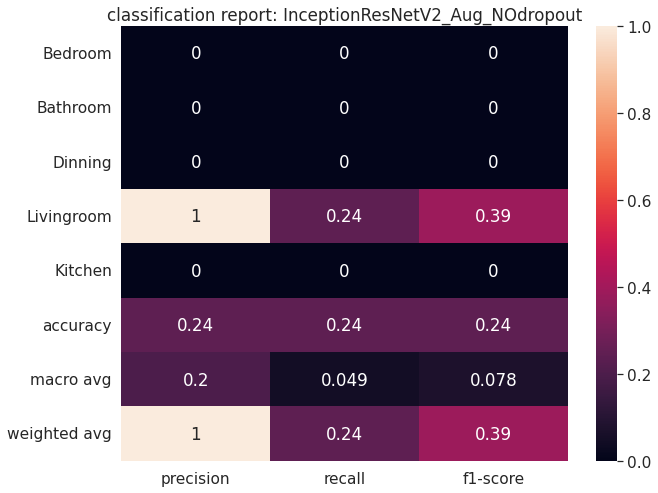

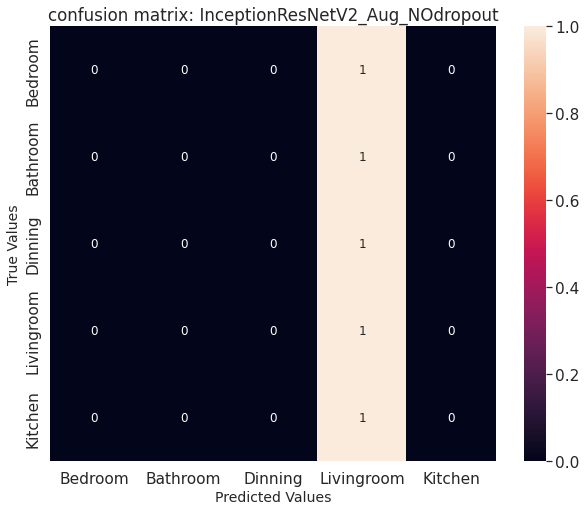


 InceptionResNetV2_dataAug_NOdropout
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_3 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_6   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 5)                 7685      
                                                                 
Total params: 54

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 18s 255ms/step - loss: 49.7965 - accuracy: 0.4587 - val_loss: 251.3730 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 4s 128ms/step - loss: 276.0132 - accuracy: 0.0062 - val_loss: 137.3480 - val_accuracy: 0.1881
Epoch 3/100
33/33 [==============================] - 4s 128ms/step - loss: 201.5891 - accuracy: 0.0589 - val_loss: 84.5280 - val_accuracy: 0.2910
Epoch 4/100
33/33 [==============================] - 4s 129ms/step - loss: 200.9323 - accuracy: 0.0547 - val_loss: 115.3150 - val_accuracy: 0.3482
Epoch 5/100
33/33 [==============================] - 4s 131ms/step - loss: 220.3897 - accuracy: 0.0760 - val_loss: 96.0295 - val_accuracy: 0.2567
Epoch 6/100
33/33 [==============================] - 4s 130ms/step - loss: 198.7828 - accuracy: 0.0556 - val_loss: 63.2197 - val_accuracy: 0.3227
Epoch 7/100
33/33 [==============================] - 4s 127ms/step - loss: 182.7793 - accuracy: 0.1383 - val_loss: 97.1386 - val_accu

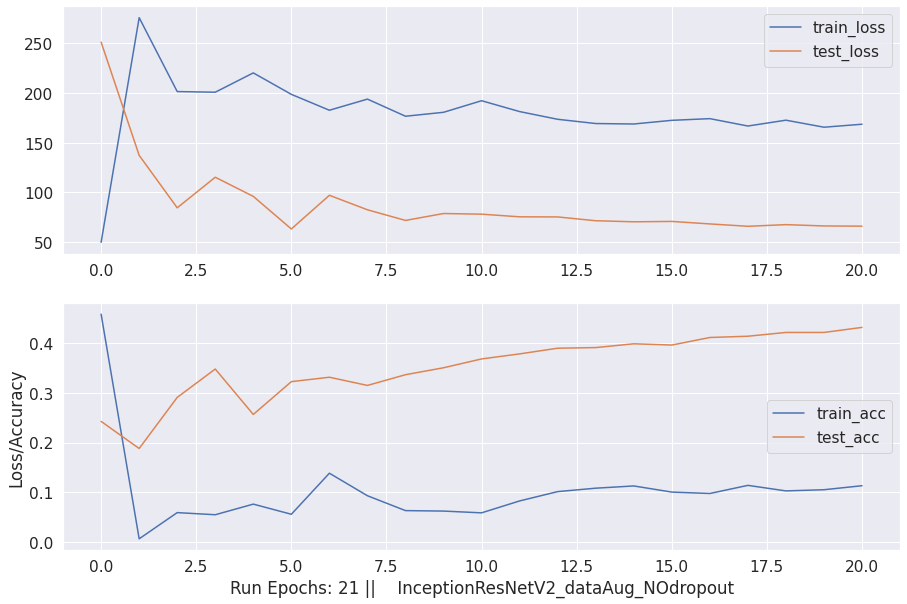

7/7 [==============================] - 1s 125ms/step - loss: 66.0292 - accuracy: 0.4320
              precision    recall  f1-score   support

     Bedroom       0.39      0.66      0.49       110
    Bathroom       0.21      0.73      0.32        26
     Dinning       0.52      0.51      0.52       175
  Livingroom       0.14      0.49      0.21        53
     Kitchen       0.92      0.31      0.47       423

    accuracy                           0.43       787
   macro avg       0.43      0.54      0.40       787
weighted avg       0.68      0.43      0.46       787



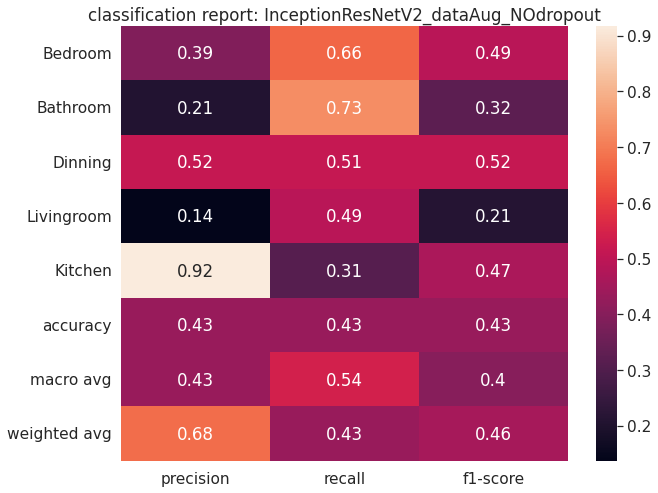

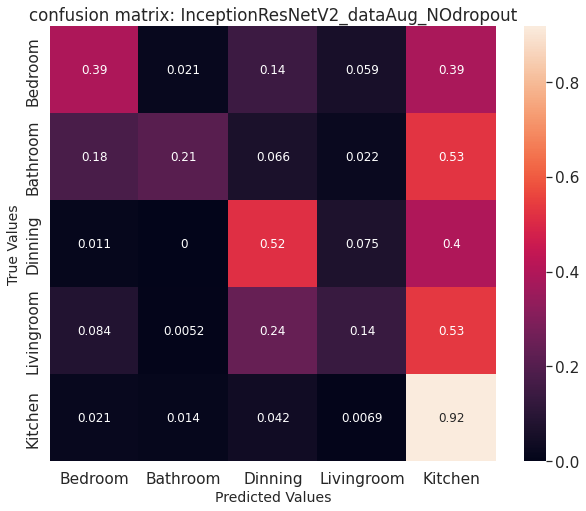


 InceptionResNetV2_dataAug_dropoutFirst02
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_4 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 2, 2, 1536)        0         
                                                                 
 global_average_pooling2d_7   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (D

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 18s 228ms/step - loss: 57.4110 - accuracy: 0.4194 - val_loss: 244.6664 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 4s 130ms/step - loss: 269.3304 - accuracy: 0.0086 - val_loss: 141.0728 - val_accuracy: 0.1868
Epoch 3/100
33/33 [==============================] - 4s 128ms/step - loss: 193.1749 - accuracy: 0.1084 - val_loss: 140.5583 - val_accuracy: 0.2757
Epoch 4/100
33/33 [==============================] - 4s 130ms/step - loss: 180.9854 - accuracy: 0.1060 - val_loss: 102.1002 - val_accuracy: 0.3316
Epoch 5/100
33/33 [==============================] - 4s 130ms/step - loss: 213.8757 - accuracy: 0.0663 - val_loss: 91.9039 - val_accuracy: 0.2427
Epoch 6/100
33/33 [==============================] - 4s 129ms/step - loss: 193.1947 - accuracy: 0.0580 - val_loss: 56.7091 - val_accuracy: 0.3774
Epoch 7/100
33/33 [==============================] - 4s 129ms/step - loss: 195.0178 - accuracy: 0.1236 - val_loss: 94.3163 - val_acc

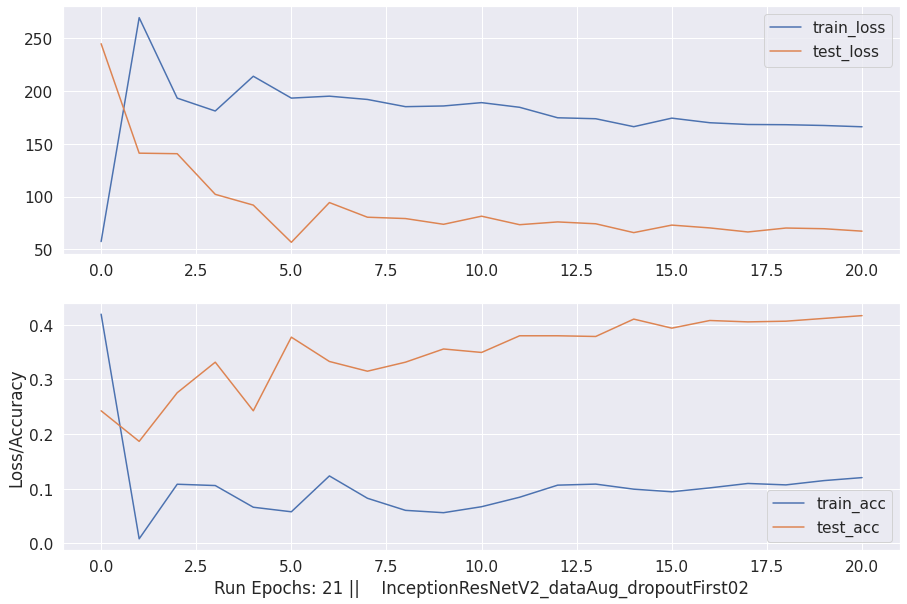

7/7 [==============================] - 1s 123ms/step - loss: 67.2503 - accuracy: 0.4168
              precision    recall  f1-score   support

     Bedroom       0.37      0.65      0.47       106
    Bathroom       0.23      0.75      0.35        28
     Dinning       0.49      0.54      0.52       159
  Livingroom       0.10      0.53      0.17        38
     Kitchen       0.92      0.29      0.44       456

    accuracy                           0.42       787
   macro avg       0.42      0.55      0.39       787
weighted avg       0.69      0.42      0.44       787



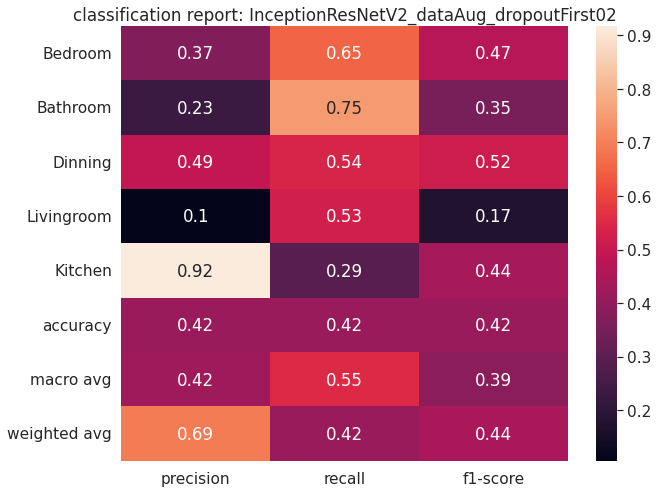

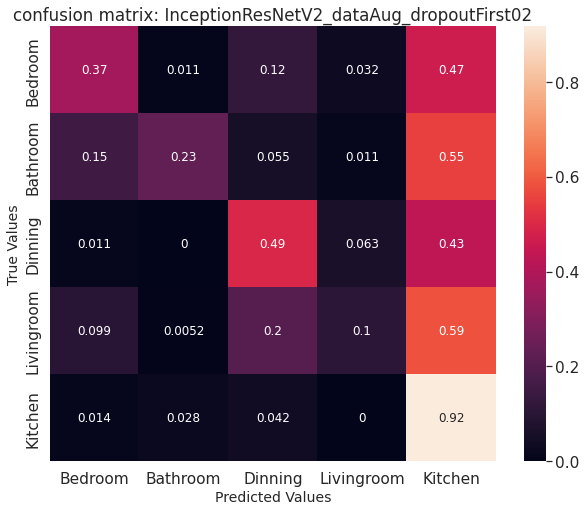


 InceptionResNetV2_NOdataAug_dropoutFirst02
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 2, 2, 1536)        0         
                                                                 
 global_average_pooling2d_8   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 5)                 7685      
                                                                 
Total params: 54,344,421
Trainable params: 7,685
Non-trainable params: 54,336,736
___________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 17s 226ms/step - loss: 840986.5625 - accuracy: 0.5924 - val_loss: 4976731.5000 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 4s 123ms/step - loss: 6694871.0000 - accuracy: 0.0000e+00 - val_loss: 3442221.2500 - val_accuracy: 0.1830
Epoch 3/100
33/33 [==============================] - 4s 126ms/step - loss: 4497843.0000 - accuracy: 0.1483 - val_loss: 5171974.0000 - val_accuracy: 0.2427
Epoch 4/100
33/33 [==============================] - 4s 126ms/step - loss: 5259783.5000 - accuracy: 0.0266 - val_loss: 2961880.7500 - val_accuracy: 0.2427
Epoch 5/100
33/33 [==============================] - 4s 128ms/step - loss: 4819553.5000 - accuracy: 0.0000e+00 - val_loss: 3985785.2500 - val_accuracy: 0.2427
Epoch 6/100
33/33 [==============================] - 4s 127ms/step - loss: 6907518.5000 - accuracy: 0.0000e+00 - val_loss: 2626943.2500 - val_accuracy: 0.1830
Epoch 7/100
33/33 [==============================] - 4s 127ms/step - l

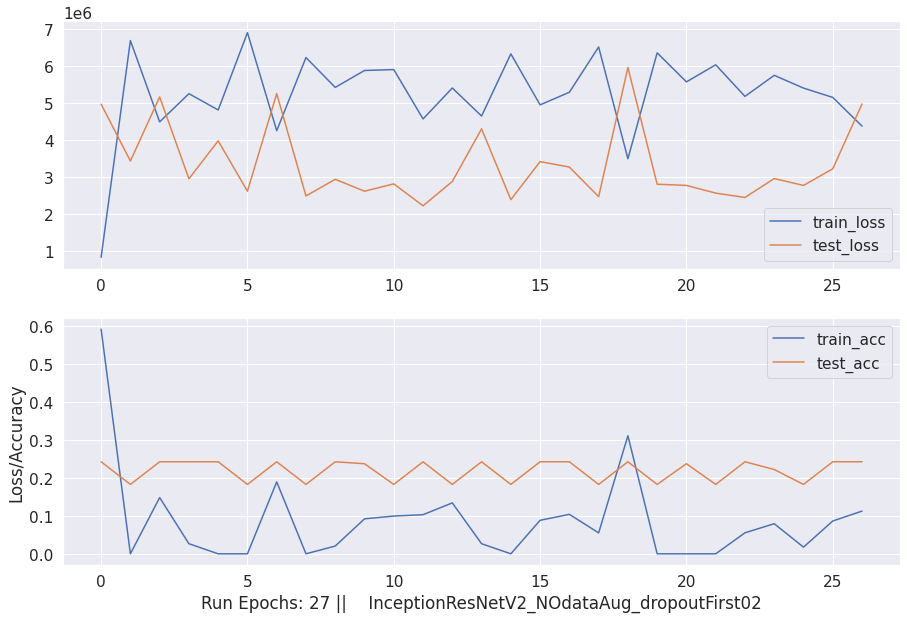

7/7 [==============================] - 1s 115ms/step - loss: 4982110.5000 - accuracy: 0.2427


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

              precision    recall  f1-score   support

     Bedroom       0.00      0.00      0.00         0
    Bathroom       0.00      0.00      0.00         0
     Dinning       0.00      0.00      0.00         0
  Livingroom       1.00      0.24      0.39       787
     Kitchen       0.00      0.00      0.00         0

    accuracy                           0.24       787
   macro avg       0.20      0.05      0.08       787
weighted avg       1.00      0.24      0.39       787



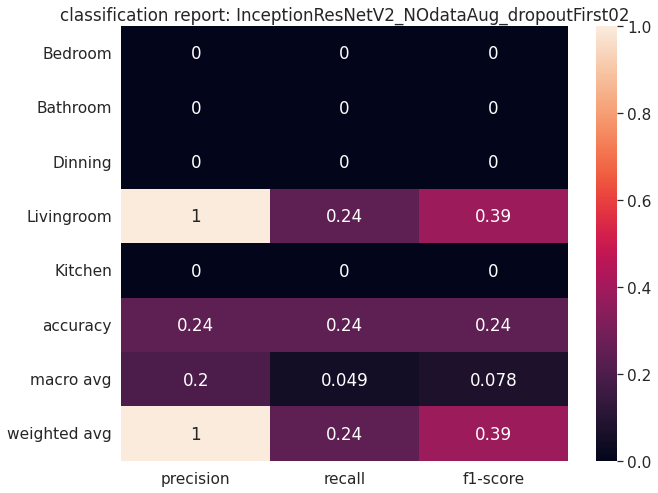

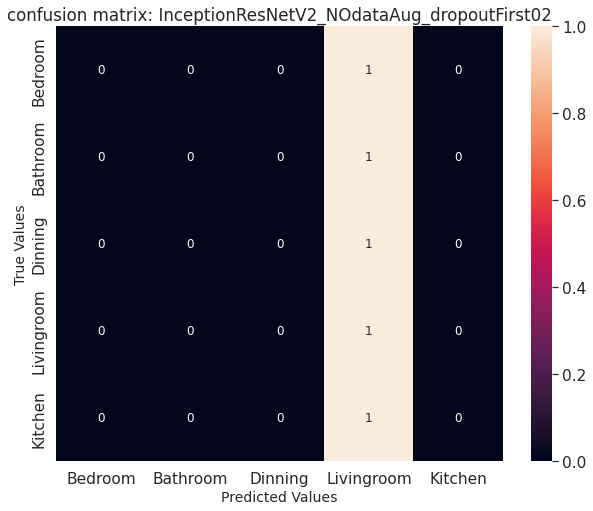


 InceptionResNetV2_dataAug_dropoutMid02
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_5 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_9   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1536)              0         
                                                                 
 dense_9 (De

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 18s 226ms/step - loss: 47.9079 - accuracy: 0.4677 - val_loss: 254.4164 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 4s 131ms/step - loss: 271.2657 - accuracy: 0.0114 - val_loss: 142.7141 - val_accuracy: 0.1830
Epoch 3/100
33/33 [==============================] - 4s 130ms/step - loss: 199.8214 - accuracy: 0.0703 - val_loss: 90.7990 - val_accuracy: 0.2706
Epoch 4/100
33/33 [==============================] - 4s 130ms/step - loss: 202.8532 - accuracy: 0.0413 - val_loss: 106.4052 - val_accuracy: 0.3227
Epoch 5/100
33/33 [==============================] - 4s 131ms/step - loss: 219.2130 - accuracy: 0.0760 - val_loss: 91.4298 - val_accuracy: 0.2808
Epoch 6/100
33/33 [==============================] - 4s 130ms/step - loss: 195.8661 - accuracy: 0.0440 - val_loss: 83.5085 - val_accuracy: 0.2745
Epoch 7/100
33/33 [==============================] - 4s 130ms/step - loss: 194.2079 - accuracy: 0.0620 - val_loss: 70.4691 - val_accu

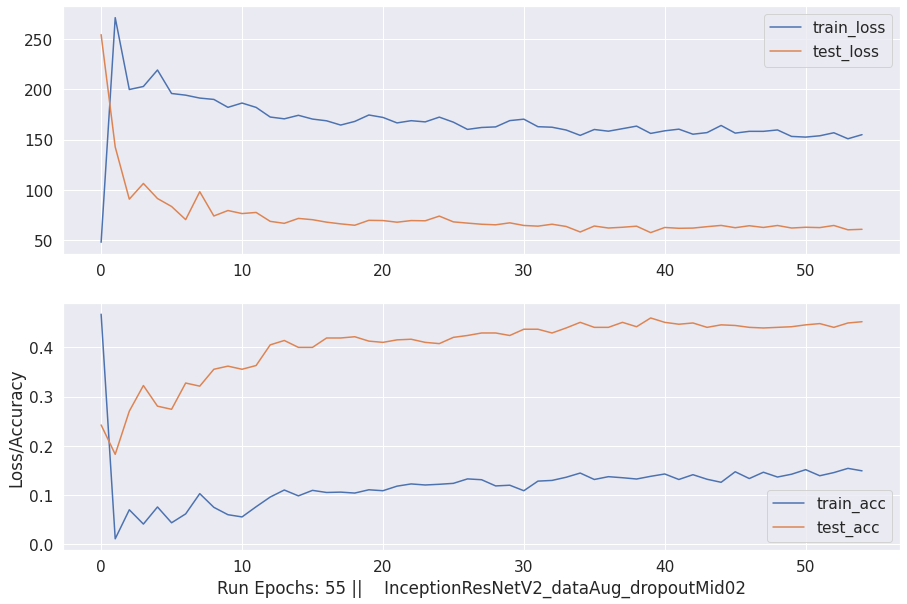

7/7 [==============================] - 1s 124ms/step - loss: 60.8348 - accuracy: 0.4524
              precision    recall  f1-score   support

     Bedroom       0.40      0.61      0.49       122
    Bathroom       0.27      0.71      0.40        35
     Dinning       0.52      0.59      0.55       152
  Livingroom       0.19      0.54      0.29        68
     Kitchen       0.90      0.31      0.47       410

    accuracy                           0.45       787
   macro avg       0.46      0.56      0.44       787
weighted avg       0.66      0.45      0.47       787



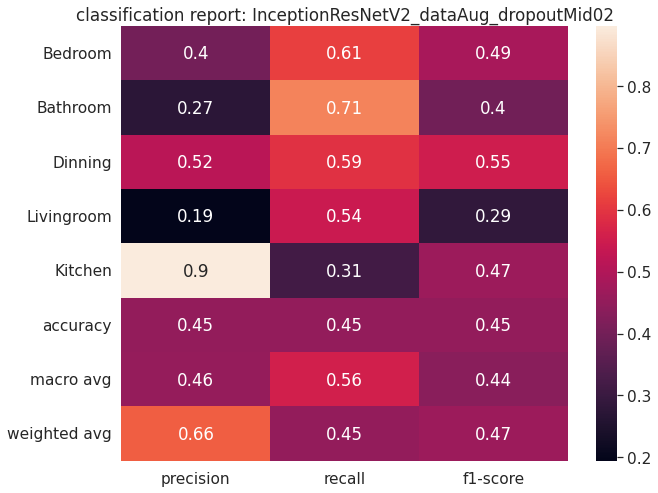

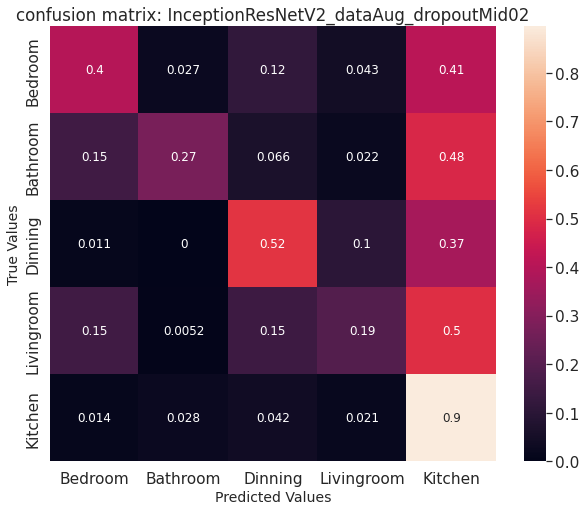


 InceptionResNetV2_NOdataAug_dropoutMid02
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_10  (None, 1536)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_7 (Dropout)         (None, 1536)              0         
                                                                 
 dense_10 (Dense)            (None, 5)                 7685      
                                                                 
Total params: 54,344,421
Trainable params: 7,685
Non-trainable params: 54,336,736
____________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 16s 220ms/step - loss: 1632916.6250 - accuracy: 0.3664 - val_loss: 5739382.5000 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 4s 129ms/step - loss: 6941145.0000 - accuracy: 0.0423 - val_loss: 3331772.0000 - val_accuracy: 0.1156
Epoch 3/100
33/33 [==============================] - 4s 127ms/step - loss: 4884936.5000 - accuracy: 0.1150 - val_loss: 2744896.0000 - val_accuracy: 0.1830
Epoch 4/100
33/33 [==============================] - 4s 124ms/step - loss: 6133901.5000 - accuracy: 0.0000e+00 - val_loss: 2600683.7500 - val_accuracy: 0.1830
Epoch 5/100
33/33 [==============================] - 4s 125ms/step - loss: 5035724.0000 - accuracy: 0.0337 - val_loss: 4099872.7500 - val_accuracy: 0.2427
Epoch 6/100
33/33 [==============================] - 4s 125ms/step - loss: 6143271.5000 - accuracy: 0.1345 - val_loss: 2672021.2500 - val_accuracy: 0.1830
Epoch 7/100
33/33 [==============================] - 4s 125ms/step - loss: 47

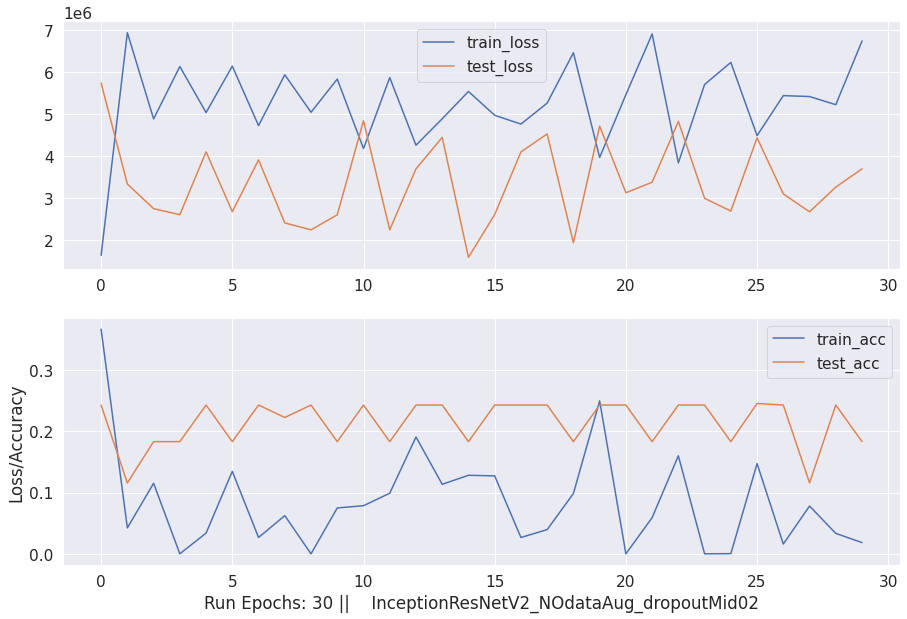

7/7 [==============================] - 1s 117ms/step - loss: 3694059.7500 - accuracy: 0.1830


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

              precision    recall  f1-score   support

     Bedroom       0.00      0.00      0.00         0
    Bathroom       0.00      0.00      0.00         0
     Dinning       0.00      0.00      0.00         0
  Livingroom       0.00      0.00      0.00         0
     Kitchen       1.00      0.18      0.31       787

    accuracy                           0.18       787
   macro avg       0.20      0.04      0.06       787
weighted avg       1.00      0.18      0.31       787



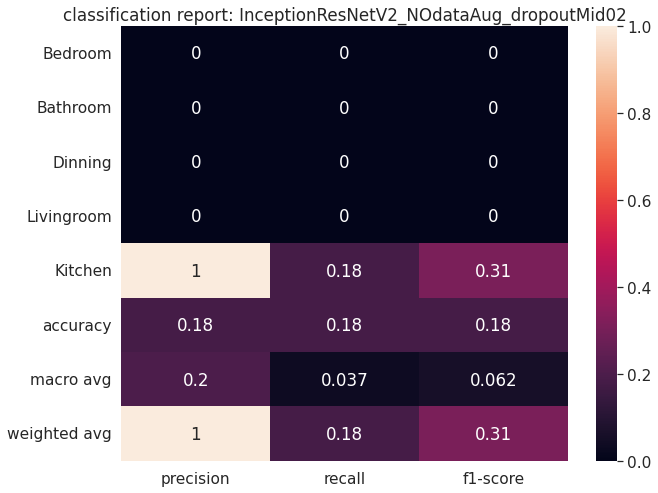

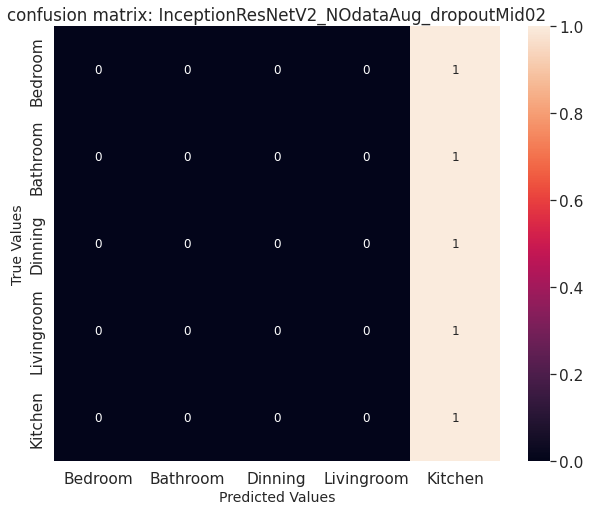


 densenet121_NOdataAug_NOdropout
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_11  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 7,042,629
Trainable params: 5,125
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 12s 182ms/step - loss: 2349.8562 - accuracy: 0.3902 - val_loss: 7181.3354 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 99ms/step - loss: 10287.6299 - accuracy: 0.0000e+00 - val_loss: 4440.9561 - val_accuracy: 0.1830
Epoch 3/100
33/33 [==============================] - 3s 100ms/step - loss: 6579.1606 - accuracy: 0.1293 - val_loss: 5282.2563 - val_accuracy: 0.2529
Epoch 4/100
33/33 [==============================] - 3s 97ms/step - loss: 7001.8037 - accuracy: 0.0292 - val_loss: 4980.5151 - val_accuracy: 0.2440
Epoch 5/100
33/33 [==============================] - 3s 99ms/step - loss: 8495.2324 - accuracy: 0.0356 - val_loss: 4193.8140 - val_accuracy: 0.1842
Epoch 6/100
33/33 [==============================] - 3s 101ms/step - loss: 6414.3140 - accuracy: 0.1395 - val_loss: 4904.7764 - val_accuracy: 0.2745
Epoch 7/100
33/33 [==============================] - 3s 101ms/step - loss: 7071.1763 - accuracy: 0.0573 - val_loss:

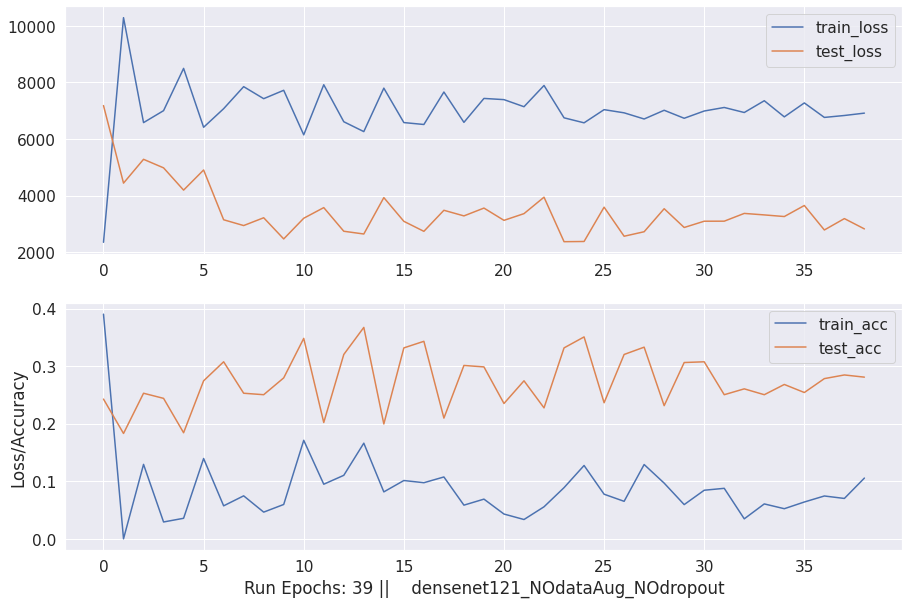

7/7 [==============================] - 1s 81ms/step - loss: 2822.7507 - accuracy: 0.2808
              precision    recall  f1-score   support

     Bedroom       0.16      0.43      0.23        67
    Bathroom       0.03      1.00      0.06         3
     Dinning       0.04      0.70      0.08        10
  Livingroom       0.31      0.41      0.36       145
     Kitchen       0.85      0.22      0.35       562

    accuracy                           0.28       787
   macro avg       0.28      0.55      0.21       787
weighted avg       0.68      0.28      0.33       787



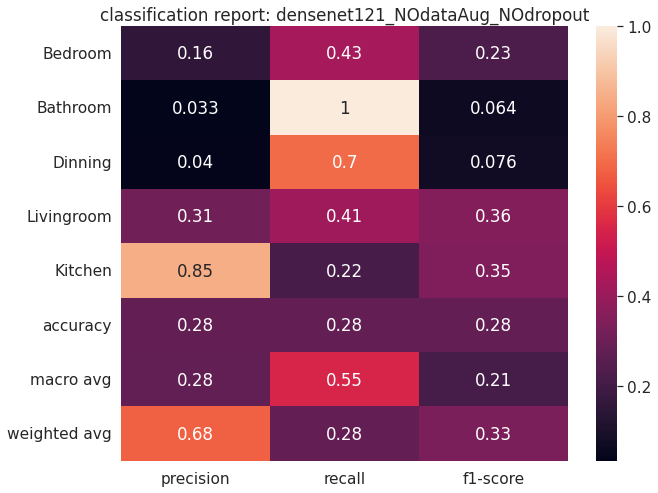

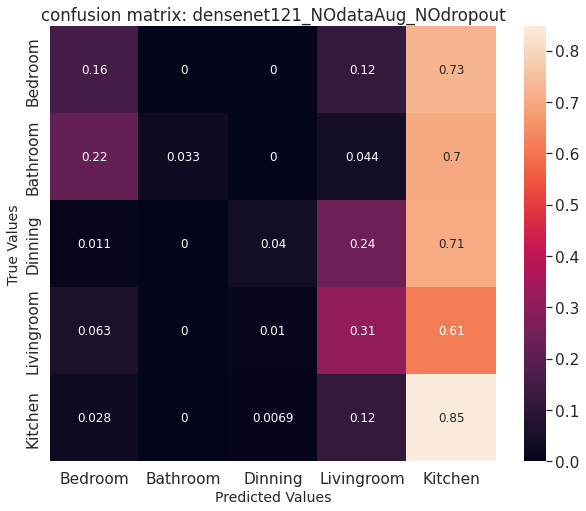


 densenet121_dataAug_NOdropout
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_6 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_12  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 7,042,629
Trainable params: 5,125
Non-trainable params: 7,037,504
_______

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 12s 176ms/step - loss: 33.7364 - accuracy: 0.4021 - val_loss: 138.6127 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 4s 108ms/step - loss: 153.6465 - accuracy: 0.0029 - val_loss: 79.3791 - val_accuracy: 0.1881
Epoch 3/100
33/33 [==============================] - 3s 102ms/step - loss: 104.8836 - accuracy: 0.0920 - val_loss: 34.5084 - val_accuracy: 0.3469
Epoch 4/100
33/33 [==============================] - 3s 103ms/step - loss: 85.1708 - accuracy: 0.2103 - val_loss: 54.9769 - val_accuracy: 0.2592
Epoch 5/100
33/33 [==============================] - 3s 101ms/step - loss: 99.1611 - accuracy: 0.1276 - val_loss: 37.0832 - val_accuracy: 0.3748
Epoch 6/100
33/33 [==============================] - 4s 107ms/step - loss: 107.2048 - accuracy: 0.0392 - val_loss: 29.5254 - val_accuracy: 0.3634
Epoch 7/100
33/33 [==============================] - 3s 102ms/step - loss: 117.1241 - accuracy: 0.0466 - val_loss: 40.6842 - val_accuracy

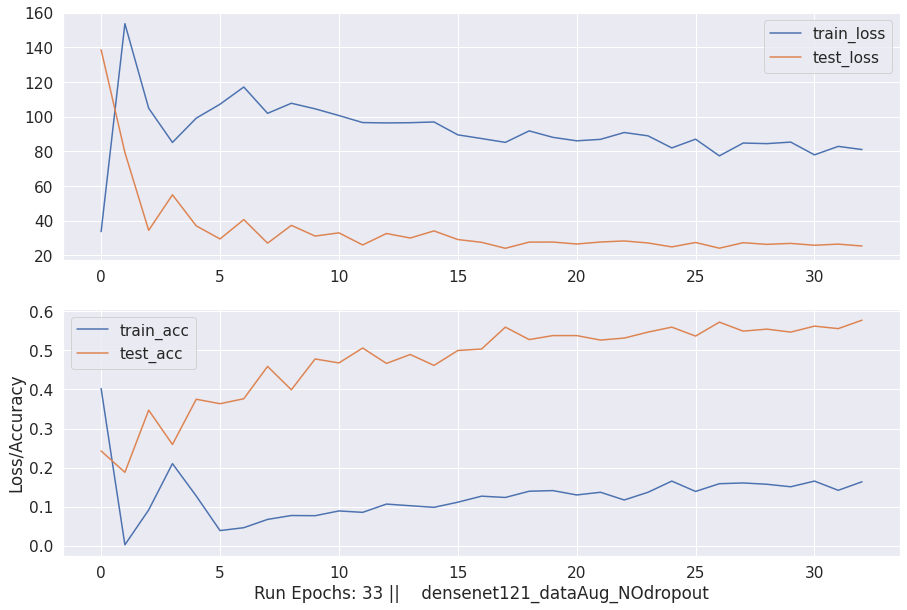

7/7 [==============================] - 1s 99ms/step - loss: 25.4536 - accuracy: 0.5769
              precision    recall  f1-score   support

     Bedroom       0.70      0.65      0.67       202
    Bathroom       0.32      0.88      0.47        33
     Dinning       0.48      0.76      0.59       109
  Livingroom       0.47      0.56      0.51       159
     Kitchen       0.85      0.43      0.57       284

    accuracy                           0.58       787
   macro avg       0.56      0.66      0.56       787
weighted avg       0.66      0.58      0.58       787



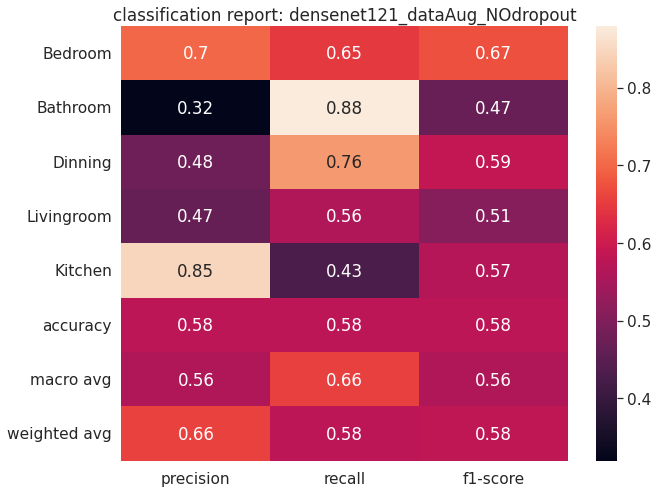

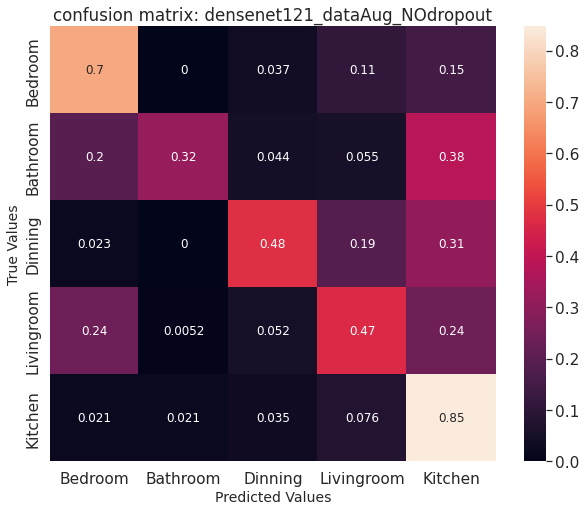


 densenet121_dataAug_dropoutFirst02
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_7 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout_8 (Dropout)         (None, 4, 4, 1024)        0         
                                                                 
 global_average_pooling2d_13  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_13 (Dense)            (None, 5)                 5125      
                

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 11s 155ms/step - loss: 31.4415 - accuracy: 0.3907 - val_loss: 136.5490 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 103ms/step - loss: 158.6028 - accuracy: 0.0050 - val_loss: 79.4746 - val_accuracy: 0.1944
Epoch 3/100
33/33 [==============================] - 3s 101ms/step - loss: 120.4677 - accuracy: 0.0913 - val_loss: 40.6810 - val_accuracy: 0.2922
Epoch 4/100
33/33 [==============================] - 3s 102ms/step - loss: 91.8950 - accuracy: 0.0901 - val_loss: 73.2437 - val_accuracy: 0.2910
Epoch 5/100
33/33 [==============================] - 3s 102ms/step - loss: 122.2629 - accuracy: 0.0715 - val_loss: 53.6419 - val_accuracy: 0.4142
Epoch 6/100
33/33 [==============================] - 3s 100ms/step - loss: 96.9121 - accuracy: 0.1366 - val_loss: 24.9382 - val_accuracy: 0.4574
Epoch 7/100
33/33 [==============================] - 3s 101ms/step - loss: 89.5696 - accuracy: 0.1830 - val_loss: 24.6630 - val_accuracy:

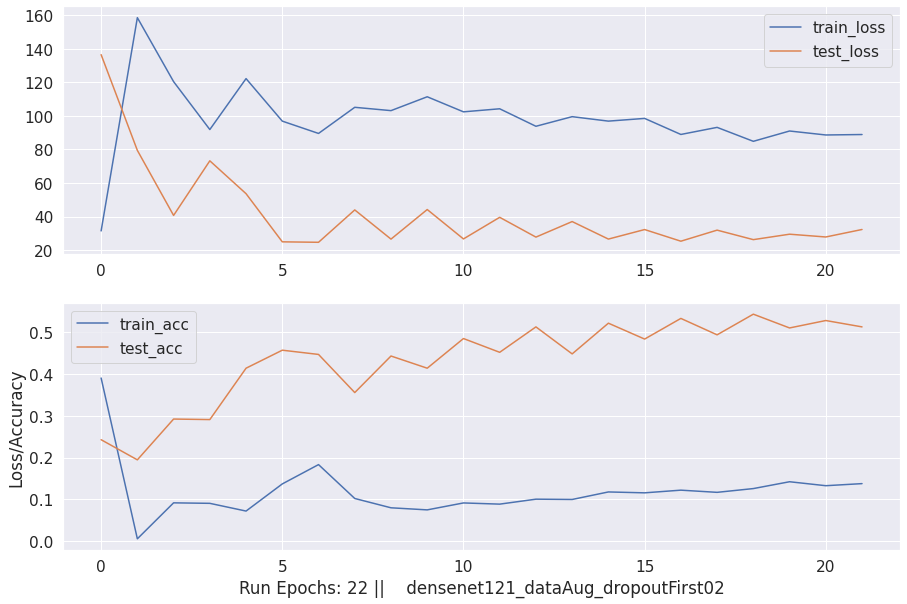

7/7 [==============================] - 1s 90ms/step - loss: 32.2981 - accuracy: 0.5133
              precision    recall  f1-score   support

     Bedroom       0.68      0.60      0.64       210
    Bathroom       0.15      0.88      0.26        16
     Dinning       0.56      0.67      0.61       147
  Livingroom       0.19      0.69      0.30        52
     Kitchen       0.90      0.36      0.51       362

    accuracy                           0.51       787
   macro avg       0.50      0.64      0.46       787
weighted avg       0.71      0.51      0.54       787



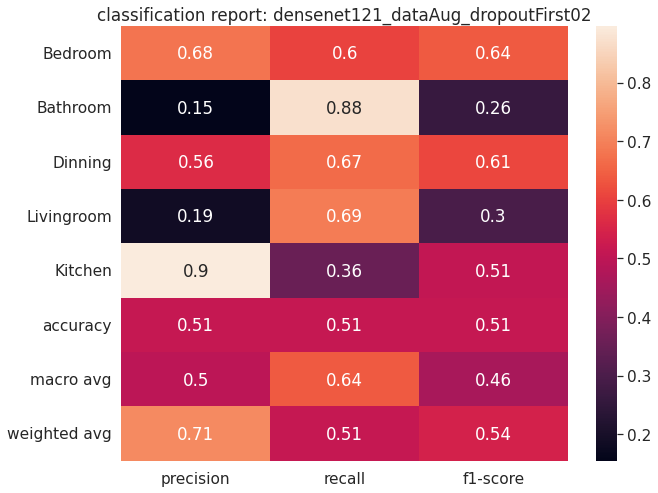

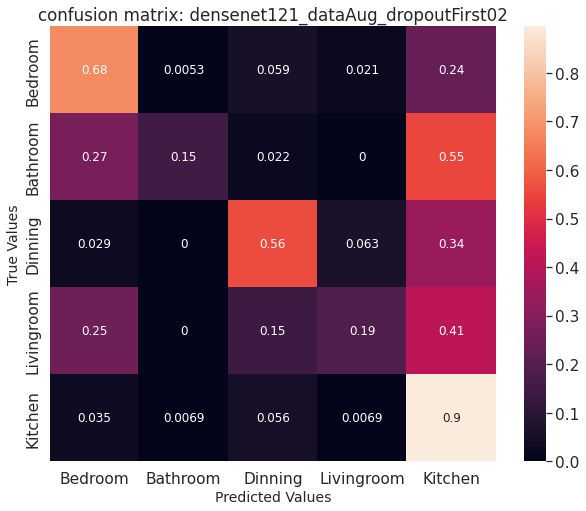


 densenet121_NOdataAug_dropoutFirst02
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 dropout_9 (Dropout)         (None, 4, 4, 1024)        0         
                                                                 
 global_average_pooling2d_14  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 7,042,629
Trainable params: 5,125
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 10s 153ms/step - loss: 2128.7117 - accuracy: 0.3921 - val_loss: 7870.5562 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 101ms/step - loss: 10432.7988 - accuracy: 0.0216 - val_loss: 5062.2412 - val_accuracy: 0.1881
Epoch 3/100
33/33 [==============================] - 3s 100ms/step - loss: 5565.2222 - accuracy: 0.1378 - val_loss: 5916.9858 - val_accuracy: 0.2592
Epoch 4/100
33/33 [==============================] - 3s 98ms/step - loss: 9793.8086 - accuracy: 0.0240 - val_loss: 4906.7759 - val_accuracy: 0.2465
Epoch 5/100
33/33 [==============================] - 3s 100ms/step - loss: 6983.2256 - accuracy: 0.1191 - val_loss: 2837.2551 - val_accuracy: 0.2935
Epoch 6/100
33/33 [==============================] - 3s 99ms/step - loss: 6943.0576 - accuracy: 0.1134 - val_loss: 2784.2205 - val_accuracy: 0.3189
Epoch 7/100
33/33 [==============================] - 3s 101ms/step - loss: 7861.5498 - accuracy: 0.0411 - val_loss: 38

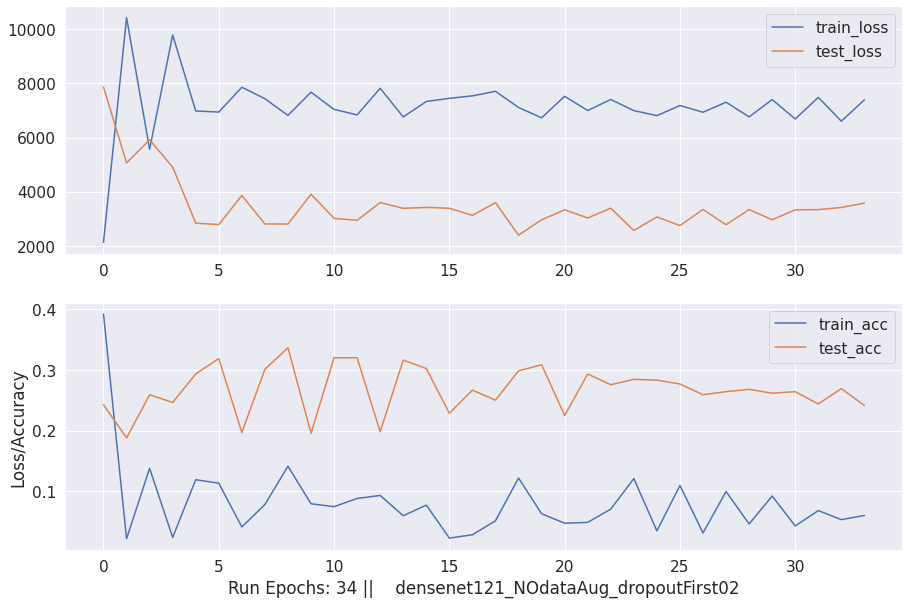

7/7 [==============================] - 1s 94ms/step - loss: 3577.2805 - accuracy: 0.2414
              precision    recall  f1-score   support

     Bedroom       0.02      0.25      0.03        12
    Bathroom       0.02      1.00      0.04         2
     Dinning       0.09      0.56      0.15        27
  Livingroom       0.15      0.58      0.24        50
     Kitchen       0.98      0.20      0.34       696

    accuracy                           0.24       787
   macro avg       0.25      0.52      0.16       787
weighted avg       0.88      0.24      0.32       787



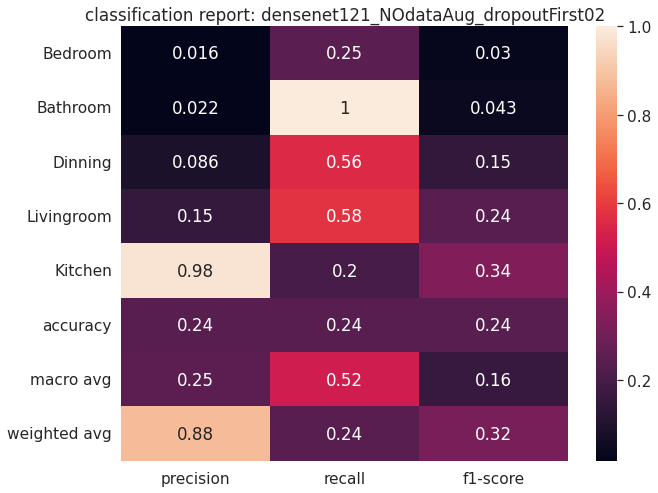

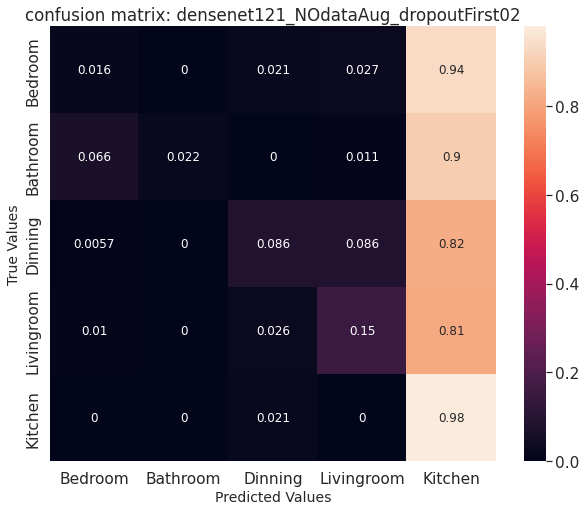


 densenet121_dataAug_dropoutMid02
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_8 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_15  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 5)                 5125      
                  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 11s 156ms/step - loss: 32.9512 - accuracy: 0.3990 - val_loss: 148.2743 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 103ms/step - loss: 155.8902 - accuracy: 0.0105 - val_loss: 72.7758 - val_accuracy: 0.1931
Epoch 3/100
33/33 [==============================] - 3s 99ms/step - loss: 97.6905 - accuracy: 0.1062 - val_loss: 48.5947 - val_accuracy: 0.3304
Epoch 4/100
33/33 [==============================] - 3s 101ms/step - loss: 109.9244 - accuracy: 0.1198 - val_loss: 36.4454 - val_accuracy: 0.3266
Epoch 5/100
33/33 [==============================] - 3s 99ms/step - loss: 113.8234 - accuracy: 0.0580 - val_loss: 38.5814 - val_accuracy: 0.3520
Epoch 6/100
33/33 [==============================] - 3s 102ms/step - loss: 106.1902 - accuracy: 0.0463 - val_loss: 27.1415 - val_accuracy: 0.4168
Epoch 7/100
33/33 [==============================] - 3s 102ms/step - loss: 115.6036 - accuracy: 0.0630 - val_loss: 38.7772 - val_accuracy:

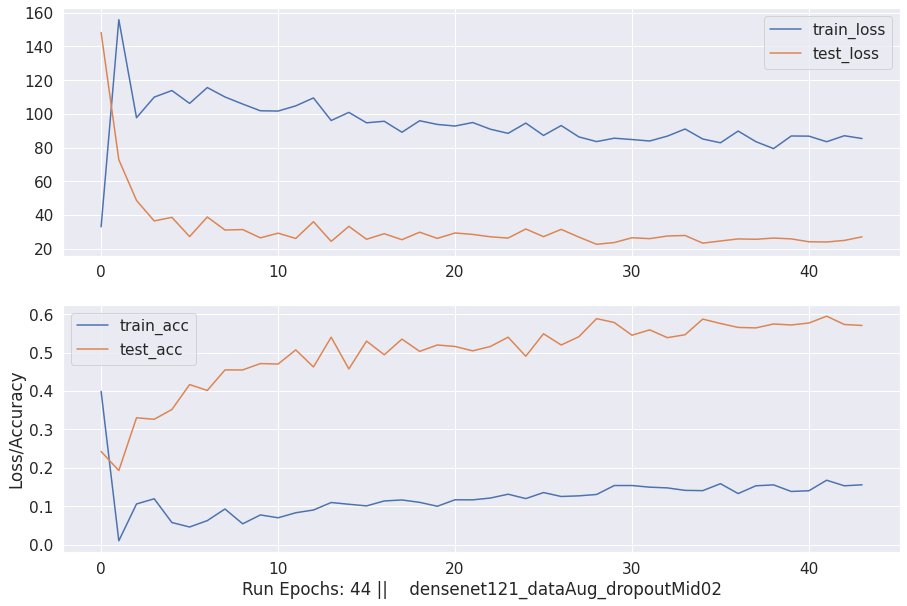

7/7 [==============================] - 1s 96ms/step - loss: 26.9996 - accuracy: 0.5705
              precision    recall  f1-score   support

     Bedroom       0.67      0.69      0.68       180
    Bathroom       0.35      0.89      0.50        36
     Dinning       0.46      0.73      0.56       110
  Livingroom       0.46      0.60      0.52       145
     Kitchen       0.87      0.40      0.54       316

    accuracy                           0.57       787
   macro avg       0.56      0.66      0.56       787
weighted avg       0.67      0.57      0.57       787



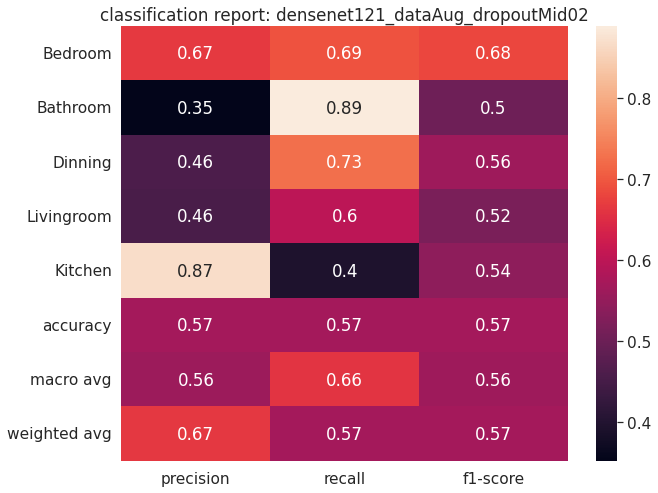

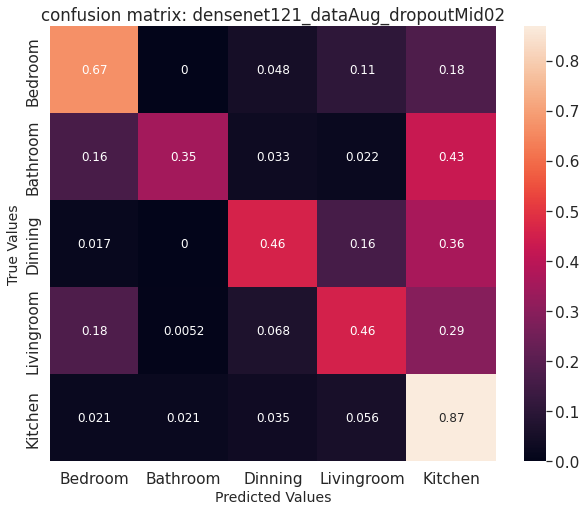


 densenet121_NOdataAug_dropoutMid02
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 global_average_pooling2d_16  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_11 (Dropout)        (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 7,042,629
Trainable params: 5,125
Non-trainable params: 7,037,504
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 10s 150ms/step - loss: 2298.2493 - accuracy: 0.4002 - val_loss: 8375.8018 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 99ms/step - loss: 10041.4062 - accuracy: 0.0183 - val_loss: 4464.6543 - val_accuracy: 0.2427
Epoch 3/100
33/33 [==============================] - 3s 100ms/step - loss: 7173.6406 - accuracy: 0.0525 - val_loss: 2684.9409 - val_accuracy: 0.2440
Epoch 4/100
33/33 [==============================] - 3s 100ms/step - loss: 7116.4561 - accuracy: 0.0615 - val_loss: 4545.7295 - val_accuracy: 0.2821
Epoch 5/100
33/33 [==============================] - 3s 102ms/step - loss: 9098.7969 - accuracy: 0.0185 - val_loss: 4348.5254 - val_accuracy: 0.1855
Epoch 6/100
33/33 [==============================] - 3s 102ms/step - loss: 6130.0483 - accuracy: 0.1647 - val_loss: 4224.5986 - val_accuracy: 0.2579
Epoch 7/100
33/33 [==============================] - 3s 101ms/step - loss: 7067.4463 - accuracy: 0.1034 - val_loss: 2

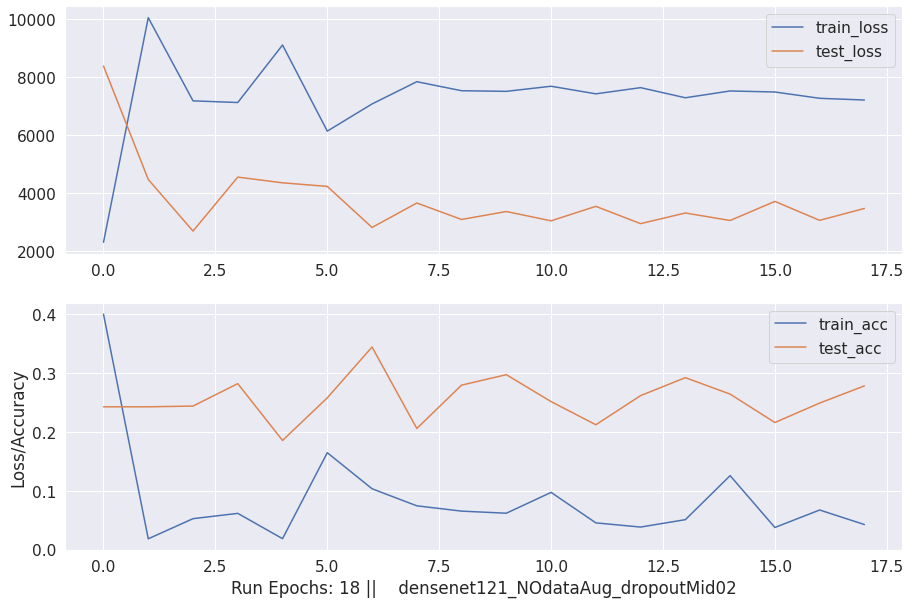

7/7 [==============================] - 1s 97ms/step - loss: 3464.7415 - accuracy: 0.2783


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

              precision    recall  f1-score   support

     Bedroom       0.00      0.00      0.00         0
    Bathroom       0.07      1.00      0.12         6
     Dinning       0.07      0.62      0.13        21
  Livingroom       0.45      0.39      0.42       218
     Kitchen       0.79      0.21      0.33       542

    accuracy                           0.28       787
   macro avg       0.28      0.44      0.20       787
weighted avg       0.67      0.28      0.35       787



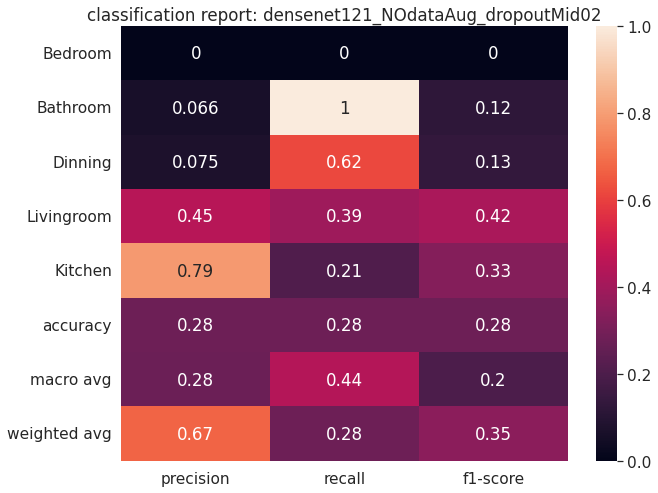

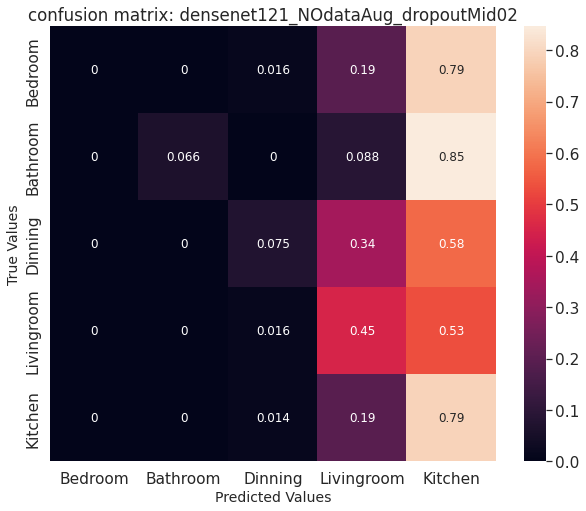


 resnet50_NOdataAug_NOdropout
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_17  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_17 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 8s 138ms/step - loss: 87.7809 - accuracy: 0.4389 - val_loss: 350.0208 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 96ms/step - loss: 440.0835 - accuracy: 0.0368 - val_loss: 215.4430 - val_accuracy: 0.2008
Epoch 3/100
33/33 [==============================] - 3s 94ms/step - loss: 289.6614 - accuracy: 0.1138 - val_loss: 143.3068 - val_accuracy: 0.3227
Epoch 4/100
33/33 [==============================] - 3s 94ms/step - loss: 332.3600 - accuracy: 0.0801 - val_loss: 134.7775 - val_accuracy: 0.3304
Epoch 5/100
33/33 [==============================] - 3s 94ms/step - loss: 258.8651 - accuracy: 0.1478 - val_loss: 101.6994 - val_accuracy: 0.4079
Epoch 6/100
33/33 [==============================] - 3s 95ms/step - loss: 247.5692 - accuracy: 0.1896 - val_loss: 99.2835 - val_accuracy: 0.4358
Epoch 7/100
33/33 [==============================] - 3s 94ms/step - loss: 220.4755 - accuracy: 0.2144 - val_loss: 88.4748 - val_accuracy:

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


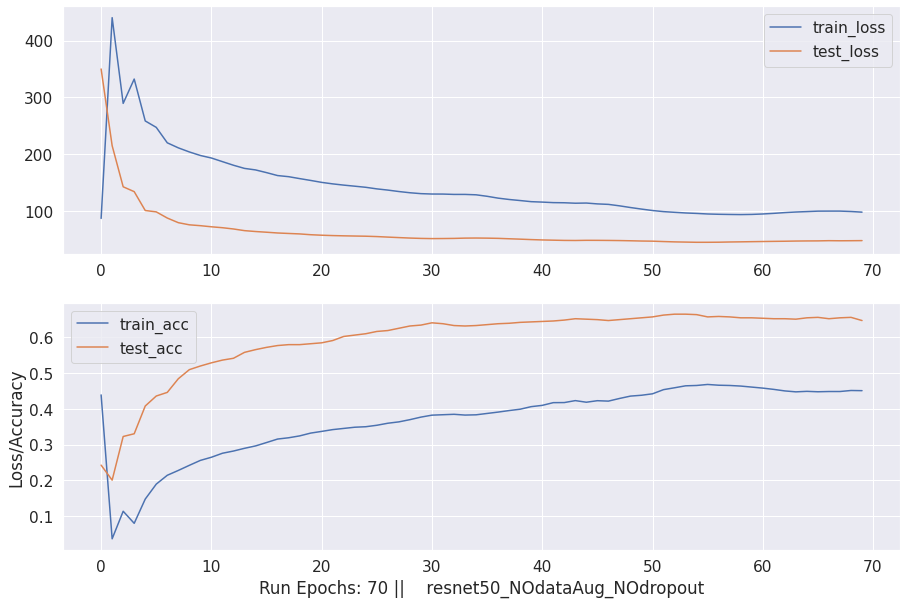

7/7 [==============================] - 1s 88ms/step - loss: 48.8624 - accuracy: 0.6468
              precision    recall  f1-score   support

     Bedroom       0.68      0.84      0.75       153
    Bathroom       0.54      0.91      0.68        54
     Dinning       0.45      0.84      0.58        93
  Livingroom       0.64      0.63      0.64       194
     Kitchen       0.91      0.45      0.60       293

    accuracy                           0.65       787
   macro avg       0.64      0.73      0.65       787
weighted avg       0.72      0.65      0.64       787



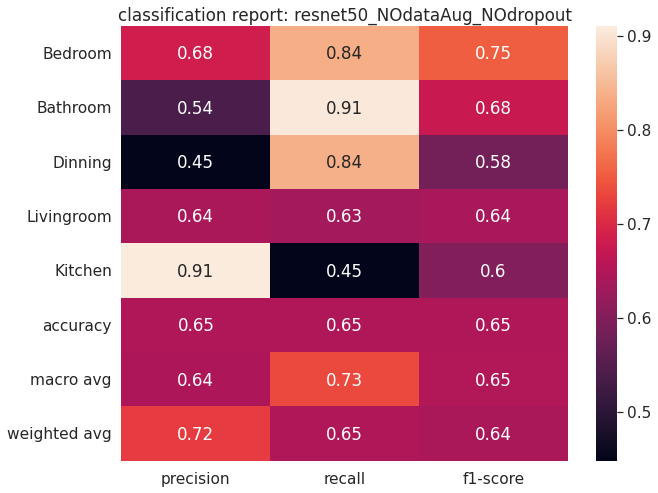

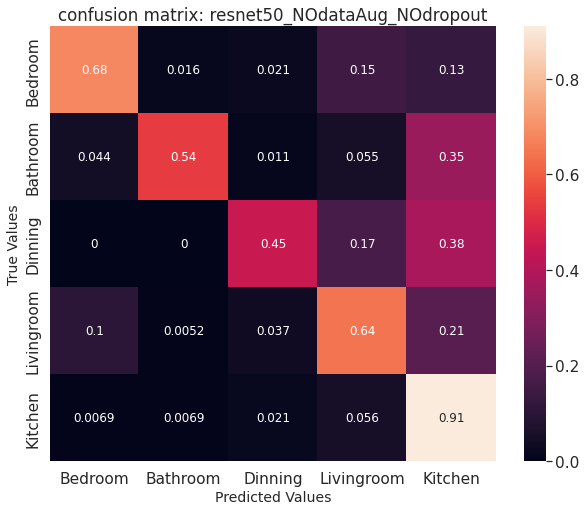


 resnet50_dataAug_NOdropout
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_9 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_18  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_______

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 9s 137ms/step - loss: 29.2230 - accuracy: 0.3664 - val_loss: 113.0001 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 4s 107ms/step - loss: 146.5750 - accuracy: 0.0000e+00 - val_loss: 75.4347 - val_accuracy: 0.1830
Epoch 3/100
33/33 [==============================] - 4s 106ms/step - loss: 81.1197 - accuracy: 0.1150 - val_loss: 88.3042 - val_accuracy: 0.2427
Epoch 4/100
33/33 [==============================] - 3s 105ms/step - loss: 107.8387 - accuracy: 0.0266 - val_loss: 53.4510 - val_accuracy: 0.1830
Epoch 5/100
33/33 [==============================] - 3s 106ms/step - loss: 93.3432 - accuracy: 0.0266 - val_loss: 71.8666 - val_accuracy: 0.2427
Epoch 6/100
33/33 [==============================] - 3s 99ms/step - loss: 143.6044 - accuracy: 0.0000e+00 - val_loss: 66.2980 - val_accuracy: 0.1830
Epoch 7/100
33/33 [==============================] - 3s 96ms/step - loss: 83.5033 - accuracy: 0.1668 - val_loss: 72.3459 - val_accu

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


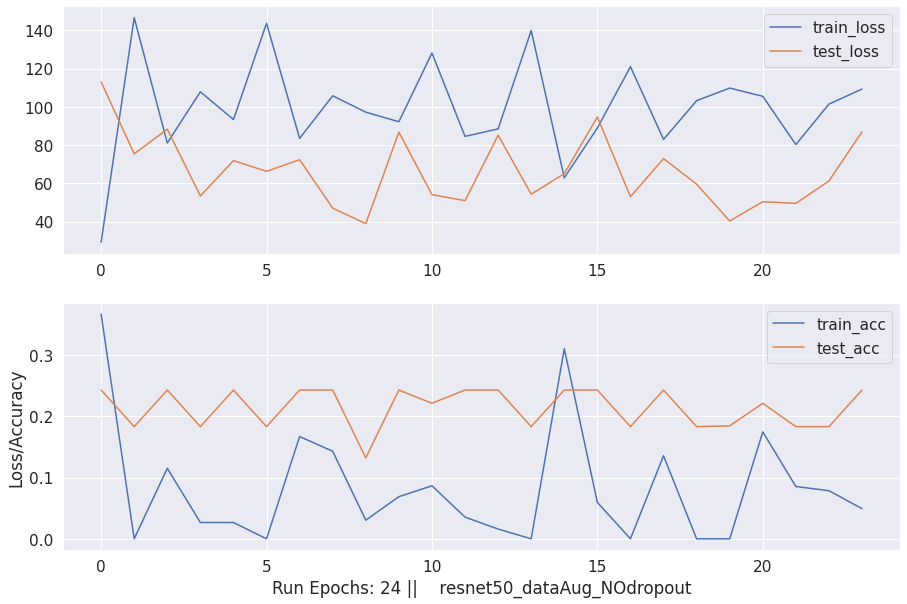

7/7 [==============================] - 1s 87ms/step - loss: 86.9621 - accuracy: 0.2427


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

              precision    recall  f1-score   support

     Bedroom       0.00      0.00      0.00         0
    Bathroom       0.00      0.00      0.00         0
     Dinning       0.00      0.00      0.00         0
  Livingroom       1.00      0.24      0.39       787
     Kitchen       0.00      0.00      0.00         0

    accuracy                           0.24       787
   macro avg       0.20      0.05      0.08       787
weighted avg       1.00      0.24      0.39       787



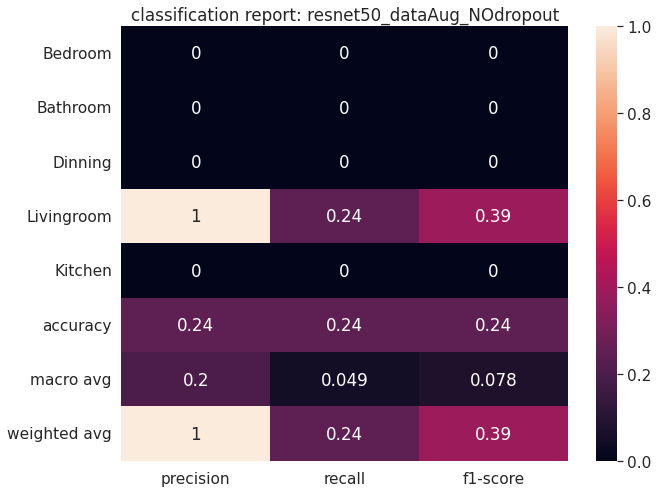

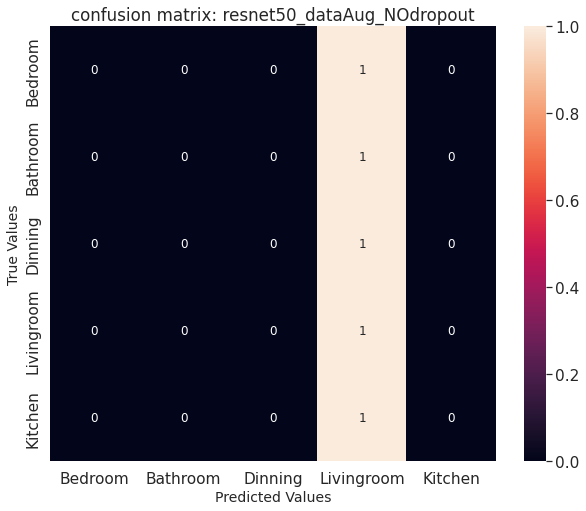


 resnet50_dataAug_dropoutFirst02
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_10 (Rescaling)    (None, None, None, 3)     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout_12 (Dropout)        (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d_19  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_19 (Dense)            (None, 5)                 10245     
                   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 7s 127ms/step - loss: 31.4998 - accuracy: 0.3664 - val_loss: 111.4659 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 99ms/step - loss: 135.8646 - accuracy: 0.0257 - val_loss: 53.8738 - val_accuracy: 0.2211
Epoch 3/100
33/33 [==============================] - 3s 98ms/step - loss: 77.8787 - accuracy: 0.0599 - val_loss: 49.0785 - val_accuracy: 0.2427
Epoch 4/100
33/33 [==============================] - 3s 99ms/step - loss: 96.7389 - accuracy: 0.0547 - val_loss: 51.8746 - val_accuracy: 0.2427
Epoch 5/100
33/33 [==============================] - 3s 99ms/step - loss: 104.9241 - accuracy: 0.0000e+00 - val_loss: 33.4531 - val_accuracy: 0.2211
Epoch 6/100
33/33 [==============================] - 3s 96ms/step - loss: 105.3563 - accuracy: 0.0993 - val_loss: 69.0141 - val_accuracy: 0.2427
Epoch 7/100
33/33 [==============================] - 3s 97ms/step - loss: 97.0674 - accuracy: 0.0677 - val_loss: 49.9336 - val_accuracy: 0.

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


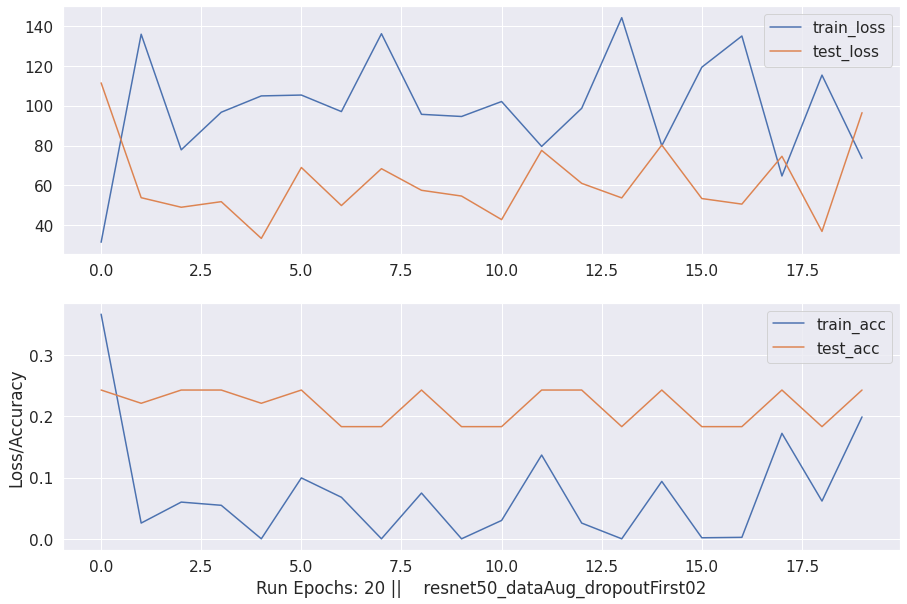

7/7 [==============================] - 1s 85ms/step - loss: 96.5153 - accuracy: 0.2427


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

              precision    recall  f1-score   support

     Bedroom       0.00      0.00      0.00         0
    Bathroom       0.00      0.00      0.00         0
     Dinning       0.00      0.00      0.00         0
  Livingroom       1.00      0.24      0.39       787
     Kitchen       0.00      0.00      0.00         0

    accuracy                           0.24       787
   macro avg       0.20      0.05      0.08       787
weighted avg       1.00      0.24      0.39       787



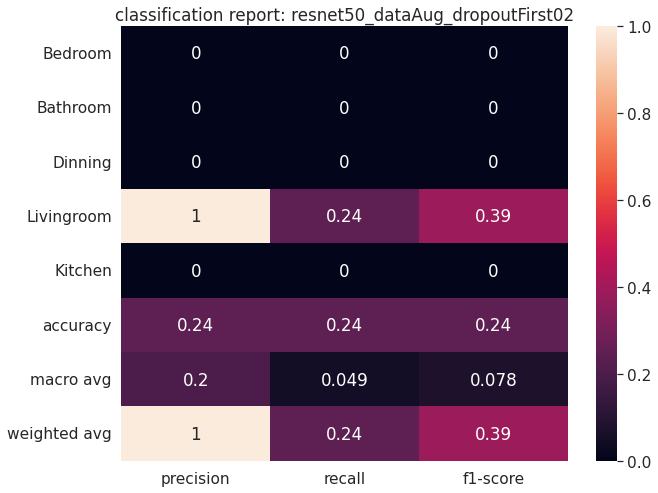

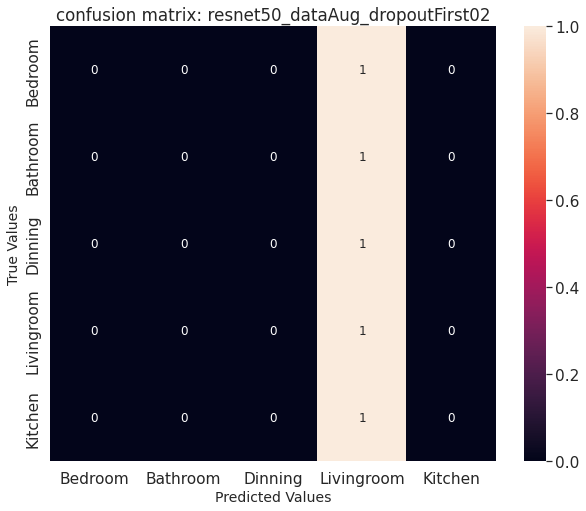


 resnet50_NOdataAug_dropoutFirst02
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout_13 (Dropout)        (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d_20  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_20 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 7s 126ms/step - loss: 96.8346 - accuracy: 0.4175 - val_loss: 337.5399 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 96ms/step - loss: 440.6050 - accuracy: 0.0366 - val_loss: 218.1989 - val_accuracy: 0.2020
Epoch 3/100
33/33 [==============================] - 3s 96ms/step - loss: 286.7787 - accuracy: 0.1110 - val_loss: 98.0968 - val_accuracy: 0.3837
Epoch 4/100
33/33 [==============================] - 3s 97ms/step - loss: 289.8824 - accuracy: 0.1226 - val_loss: 90.7551 - val_accuracy: 0.4053
Epoch 5/100
33/33 [==============================] - 3s 95ms/step - loss: 266.0043 - accuracy: 0.1476 - val_loss: 108.6464 - val_accuracy: 0.3914
Epoch 6/100
33/33 [==============================] - 3s 96ms/step - loss: 253.0027 - accuracy: 0.1849 - val_loss: 111.1658 - val_accuracy: 0.4041
Epoch 7/100
33/33 [==============================] - 3s 96ms/step - loss: 229.7129 - accuracy: 0.2008 - val_loss: 95.0124 - val_accuracy: 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


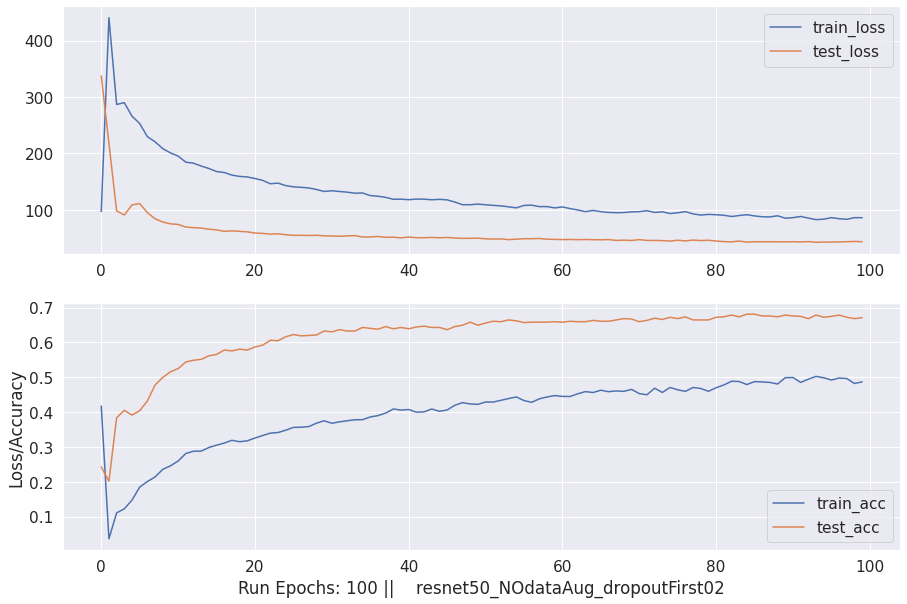

7/7 [==============================] - 1s 81ms/step - loss: 43.4730 - accuracy: 0.6709
              precision    recall  f1-score   support

     Bedroom       0.72      0.85      0.78       158
    Bathroom       0.57      0.91      0.70        57
     Dinning       0.51      0.82      0.63       108
  Livingroom       0.65      0.63      0.64       199
     Kitchen       0.89      0.48      0.63       265

    accuracy                           0.67       787
   macro avg       0.67      0.74      0.68       787
weighted avg       0.72      0.67      0.67       787



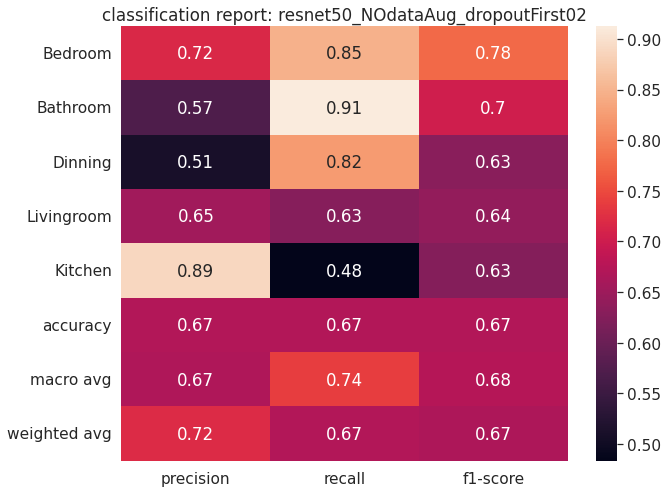

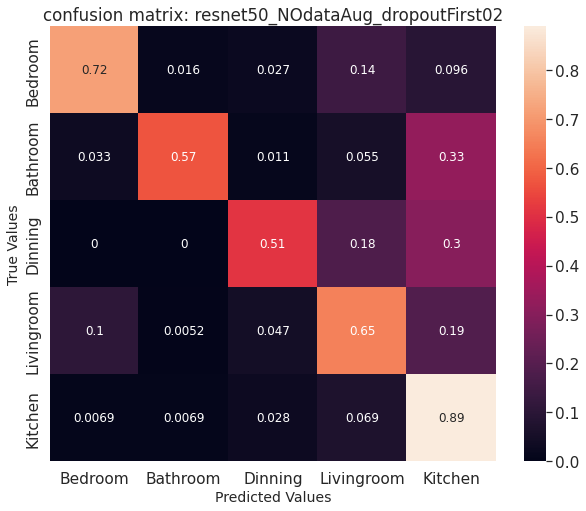


 resnet50_dataAug_dropoutMid02
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling_11 (Rescaling)    (None, None, None, 3)     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_21  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0         
                                                                 
 dense_21 (Dense)            (None, 5)                 10245     
                     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 8s 130ms/step - loss: 28.5461 - accuracy: 0.3798 - val_loss: 114.9428 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 96ms/step - loss: 145.9489 - accuracy: 0.0000e+00 - val_loss: 64.8386 - val_accuracy: 0.1830
Epoch 3/100
33/33 [==============================] - 3s 95ms/step - loss: 80.6041 - accuracy: 0.1820 - val_loss: 80.1365 - val_accuracy: 0.2427
Epoch 4/100
33/33 [==============================] - 3s 97ms/step - loss: 92.4506 - accuracy: 0.0870 - val_loss: 99.3510 - val_accuracy: 0.2427
Epoch 5/100
33/33 [==============================] - 3s 93ms/step - loss: 126.3359 - accuracy: 0.0404 - val_loss: 56.2440 - val_accuracy: 0.1830
Epoch 6/100
33/33 [==============================] - 3s 96ms/step - loss: 71.3355 - accuracy: 0.1835 - val_loss: 88.1631 - val_accuracy: 0.2427
Epoch 7/100
33/33 [==============================] - 3s 97ms/step - loss: 105.3499 - accuracy: 0.0955 - val_loss: 46.3954 - val_accuracy: 0.

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


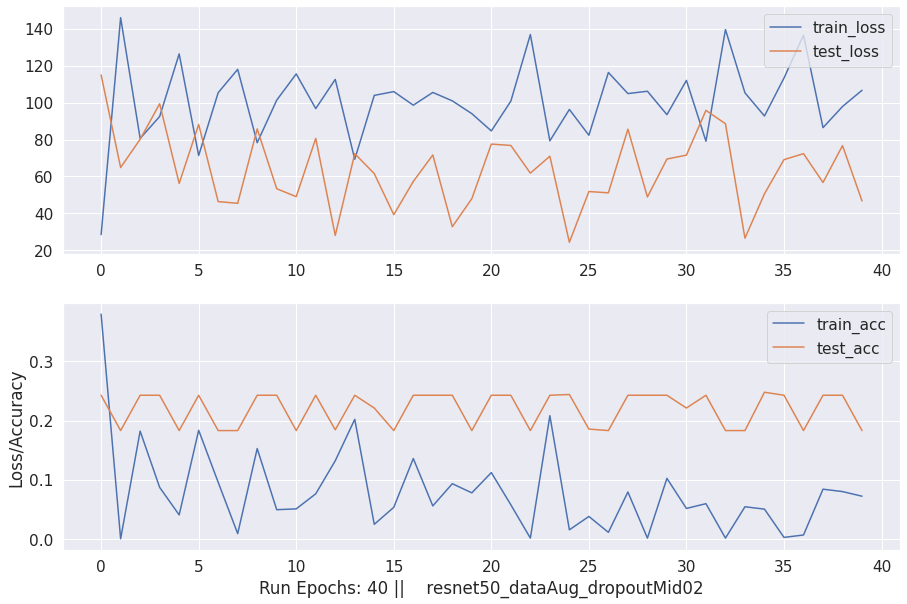

7/7 [==============================] - 1s 85ms/step - loss: 46.7530 - accuracy: 0.1830


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMe

              precision    recall  f1-score   support

     Bedroom       0.00      0.00      0.00         0
    Bathroom       0.00      0.00      0.00         0
     Dinning       0.00      0.00      0.00         0
  Livingroom       0.00      0.00      0.00         0
     Kitchen       1.00      0.18      0.31       787

    accuracy                           0.18       787
   macro avg       0.20      0.04      0.06       787
weighted avg       1.00      0.18      0.31       787



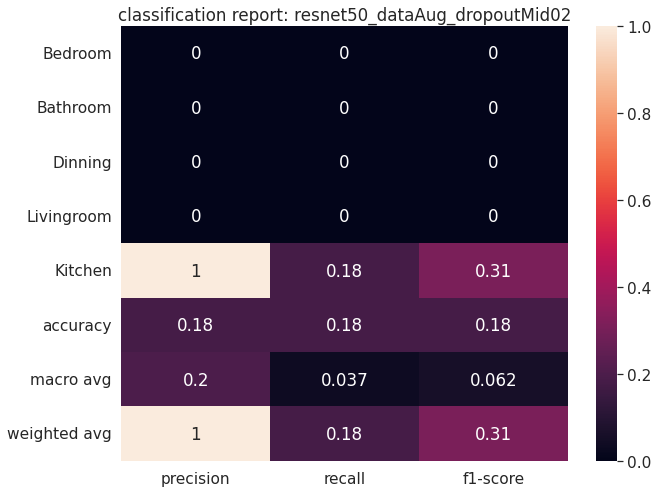

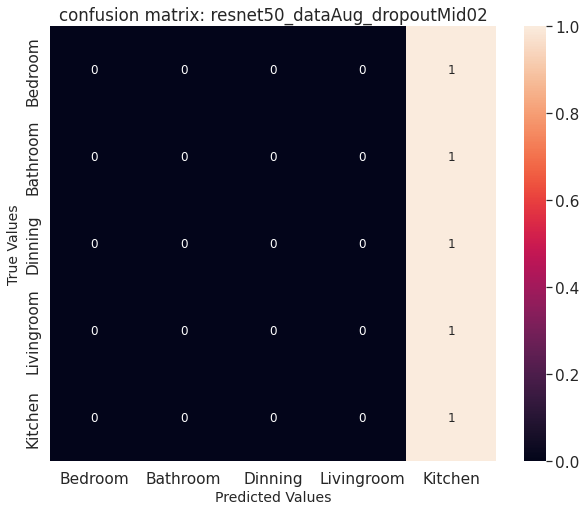


 resnet50_NOdataAug_dropoutMid02
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_22  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_15 (Dropout)        (None, 2048)              0         
                                                                 
 dense_22 (Dense)            (None, 5)                 10245     
                                                                 
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 7s 127ms/step - loss: 56.2813 - accuracy: 0.5856 - val_loss: 321.2813 - val_accuracy: 0.2427
Epoch 2/100
33/33 [==============================] - 3s 96ms/step - loss: 382.3084 - accuracy: 0.0228 - val_loss: 204.9288 - val_accuracy: 0.1931
Epoch 3/100
33/33 [==============================] - 3s 98ms/step - loss: 363.7570 - accuracy: 0.0397 - val_loss: 103.6525 - val_accuracy: 0.3240
Epoch 4/100
33/33 [==============================] - 3s 98ms/step - loss: 293.3224 - accuracy: 0.0967 - val_loss: 118.3455 - val_accuracy: 0.3596
Epoch 5/100
33/33 [==============================] - 3s 96ms/step - loss: 272.0584 - accuracy: 0.1485 - val_loss: 111.6242 - val_accuracy: 0.3875
Epoch 6/100
33/33 [==============================] - 3s 98ms/step - loss: 244.7466 - accuracy: 0.2032 - val_loss: 105.2824 - val_accuracy: 0.4079
Epoch 7/100
33/33 [==============================] - 3s 96ms/step - loss: 229.5873 - accuracy: 0.2134 - val_loss: 94.0570 - val_accuracy

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


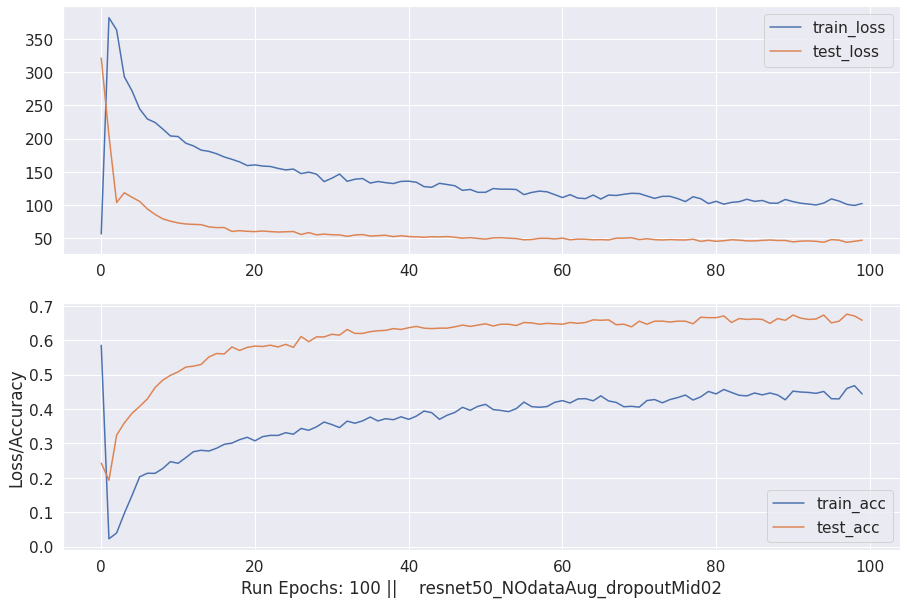

7/7 [==============================] - 1s 86ms/step - loss: 46.8391 - accuracy: 0.6582
              precision    recall  f1-score   support

     Bedroom       0.66      0.85      0.74       144
    Bathroom       0.59      0.86      0.70        63
     Dinning       0.49      0.86      0.63       100
  Livingroom       0.64      0.63      0.64       196
     Kitchen       0.92      0.46      0.62       284

    accuracy                           0.66       787
   macro avg       0.66      0.73      0.66       787
weighted avg       0.72      0.66      0.65       787



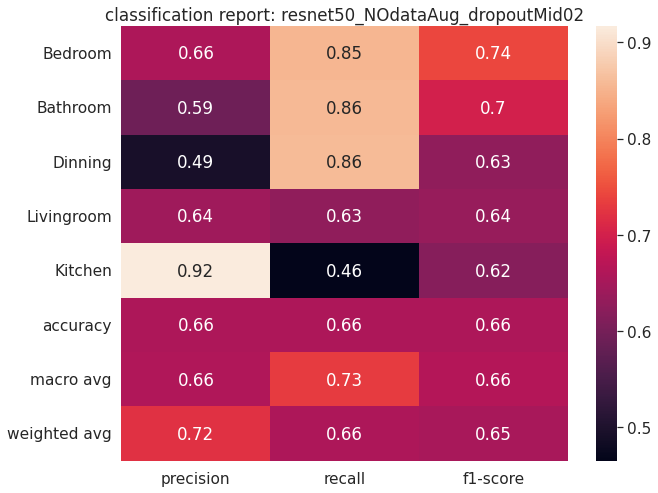

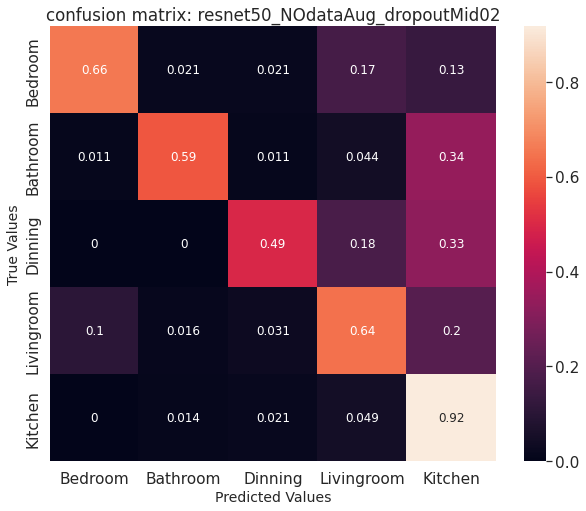

In [ ]:
epochs = 100
for m in models_dict:
  print("\n", m)
  models_dict[m].summary()

  models_dict[m].compile( optimizer = opt, #"adam", 
                loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', 
                metrics=['accuracy'] # "recall"
                )

  history = models_dict[m].fit(
        train_ds,
        validation_data=test_ds,
        epochs=epochs,
        callbacks = callbacks # <=== REMOVE CALLBACK for full results
        )
  
  number_of_epochs_it_ran = len(history.history['loss']) 
  print("run epochs: ",number_of_epochs_it_ran)
  name = m
  models_dict[m].save(output_folder+name+".h5")

  # saving model accuracy/loss graph
  plotting_model(history,number_of_epochs_it_ran, name, output_folder+name+"-loss_accuracy.png") 
  
  # saving model metrics to json
  evaluation = models_dict[m].evaluate(test_ds, batch_size=batch_size, return_dict=True)
  model_evaluation(evaluation, output_folder, name)

  # get inferences
  y_pred_float = models_dict[m].predict(test_ds)
  y_pred = np.argmax(y_pred_float, axis=1)

  # get real labels
  y_target = tf.concat([y for x, y in test_ds], axis=0) 

  # classification and confusion matrix reports
  classification_report_pic(y_pred, y_target,  class_names, output_folder, name)
  confusion_matrix_report(y_pred, y_target, class_names, output_folder, name)

- load a trained model

In [ ]:
# error above for misplacing y_pred and test_ds in function args
'''densenet121 = load_model(output_folder+"densenet121_dataAug_dropoutFirst02.h5")
evaluation  = densenet121.evaluate(testds, batch_size=batch_size, return_dict=True)'''

'densenet121 = load_model(output_folder+"densenet121_dataAug_dropoutFirst02.h5")\nevaluation  = densenet121.evaluate(testds, batch_size=batch_size, return_dict=True)'

In [ ]:
# saving model metrics to json
'''model_evaluation(evaluation, output_folder, "densenet121_dataAug_dropoutFirst02.h5")'''

'model_evaluation(evaluation, output_folder, "densenet121_dataAug_dropoutFirst02.h5")'

In [ ]:
# get inferences
'''y_pred_float = models_dict[m].predict(test_ds)
y_pred = np.argmax(y_pred_float, axis=1) '''

'y_pred_float = models_dict[m].predict(test_ds)\ny_pred = np.argmax(y_pred_float, axis=1) '

In [ ]:
# classification and confusion matrix reports
'''classification_report_pic(y_pred, val_ds,  class_names, output_folder, "densenet121_dataAug_dropoutFirst02.h5")
confusion_matrix_report(y_pred, val_ds, class_names, output_folder, "densenet121_dataAug_dropoutFirst02.h5")'''

'classification_report_pic(y_pred, val_ds,  class_names, output_folder, "densenet121_dataAug_dropoutFirst02.h5")\nconfusion_matrix_report(y_pred, val_ds, class_names, output_folder, "densenet121_dataAug_dropoutFirst02.h5")'